In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pandas_profiling
import math
import seaborn as sns
import gc

from datetime import datetime
from pygeocoder import Geocoder

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def currency(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '${:1.1f}M'.format(x*1e-6)
    elif x >= 1000000:
        return '${:1.1f}K'.format(x*1e-3)
    return '${:1.0f}'.format(x*1e-0)

def number(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '{:1.1f}M'.format(x*1e-6)
    elif x >= 100000:
        return '{:1.1f}K'.format(x*1e-3)
    return '{:1.0f}'.format(x*1e-0)

In [4]:
#numRows = 50000  # 50 thousand
#numRows = 500000  # 500 thousand
#numRows = 1000000  # 1 million
numRows = 1000000000  # 1 billion
dt = "Feb 2013"
fileMonth = "2"

In [5]:
my_colors =[
            '#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A',
            '#D62728', '#FF9896', '#9467BD', '#C5B0D5', '#8C564B', '#C49C94',
            '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7', '#BCBD22', '#DBDB8D',
            '#17BECF', '#9EDAE5'
        ]

In [6]:
#set the fonts that are on the box so as to stop the warning messages
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Read Data

In [7]:
tripData1 = pd.read_csv('/dltraining/datasets/Trip Data/trip_data_' + fileMonth + '.csv', nrows = numRows)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
tripData1.head()

medallion                      hack_license  \
0  1B5C0970F2AE8CFFBA8AE4584BEAED29  D961332334524990D1BBD462E2EFB8A4   
1  B42249AE16E2B8E556F1CB1F940D6FB4  D4BB308D1F3FCB3434D9DB282CDC93D7   
2  890699222C47C09FBC898758CEC69762  6318C3AEC02248928C3345B5805EB905   
3  74B7D835C2CD98606D5256DA8A38E045  D5E278C918256D1F97680A1F04D290E0   
4  4003B8478418FEC5D761E2F37602769B  0B766F1054A5C16D86BC023858BD8143   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-02-08 23:35:14   
1       CMT          1                  N  2013-02-07 12:20:16   
2       CMT          1                  N  2013-02-08 08:56:54   
3       CMT          1                  N  2013-02-08 09:37:02   
4       CMT          1                  N  2013-02-08 19:31:25   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-02-08 23:42:58                1                463            0.8   
1  2013-02-07 12:50:27                4               1810            3.1   
2  2013-02-08 08:59:43                1                168            1.0   
3  2013-02-08 09:50:50                1                828            2.1   
4  2013-02-08 19:46:23                1                897            3.3   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  
0        -73.992439        40.724487         -73.984421         40.718903  
1        -73.989494        40.769588         -73.990303         40.737347  
2        -73.963036        40.799141         -73.972168         40.786446  
3        -73.987953        40.728764         -74.007118         40.705399  
4        -73.987282        40.743042         -74.010284         40.703964

In [9]:
# work out the min and max dates of the pickup time.
minPickup=min(tripData1['pickup_datetime'])
maxPickup=max(tripData1['pickup_datetime'])
print('MinPickup: %s, Max Pickup: %s' % (minPickup, maxPickup))

MinPickup: 2013-02-01 00:00:00, Max Pickup: 2013-02-28 23:59:59


In [10]:
#convert to datetime
tripData1.loc[:, 'pickup_datetime_dt'] = pd.to_datetime(tripData1.loc[:, 'pickup_datetime'])
tripData1.loc[:, 'dropoff_datetime_dt'] = pd.to_datetime(tripData1.loc[:, 'dropoff_datetime'])

In [11]:
tripFare1 = pd.read_csv('/dltraining/datasets/Trip Fare/trip_fare_' + fileMonth + '.csv', nrows = numRows) 

#remove the leading spaces
tripFare1.columns = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax',
       'tip_amount', 'tolls_amount', 'total_amount']

In [12]:
tripFare1.head()

medallion                      hack_license  \
0  1B5C0970F2AE8CFFBA8AE4584BEAED29  D961332334524990D1BBD462E2EFB8A4   
1  B42249AE16E2B8E556F1CB1F940D6FB4  D4BB308D1F3FCB3434D9DB282CDC93D7   
2  890699222C47C09FBC898758CEC69762  6318C3AEC02248928C3345B5805EB905   
3  74B7D835C2CD98606D5256DA8A38E045  D5E278C918256D1F97680A1F04D290E0   
4  4003B8478418FEC5D761E2F37602769B  0B766F1054A5C16D86BC023858BD8143   

  vendor_id      pickup_datetime payment_type  fare_amount  surcharge  \
0       CMT  2013-02-08 23:35:14          CRD          6.0        0.5   
1       CMT  2013-02-07 12:20:16          CRD         20.0        0.0   
2       CMT  2013-02-08 08:56:54          CRD          5.0        0.0   
3       CMT  2013-02-08 09:37:02          CRD         11.0        0.0   
4       CMT  2013-02-08 19:31:25          CRD         13.0        1.0   

   mta_tax  tip_amount  tolls_amount  total_amount  
0      0.5         0.0           0.0           7.0  
1      0.5         3.0           0.0          23.5  
2      0.5         1.1           0.0           6.6  
3      0.5         2.3           0.0          13.8  
4      0.5         1.5           0.0          16.0

In [13]:
#convert to datetime
tripFare1.loc[:, 'pickup_datetime_dt'] = pd.to_datetime(tripFare1.loc[:, 'pickup_datetime'])

# Profile the data

if numRows < 100000:
    pandas_profiling.ProfileReport(tripFare1)

if numRows < 100000:
    pandas_profiling.ProfileReport(tripData1)

# Dropping null data

Wanting to only include valid trips within the New York Region

# Boundaries of New York (Lat/Long)
<ul>
  <li>40.706041, -73.927436 - Centre of New York</li>
  <li>41.411137, -74.997657 - Top Left</li>
  <li>40.027137, -74.893068 - Bottom Left</li>
  <li>41.937288, -71.428648 - Top Right</li>
  <li>39.905568, -71.365129 - Bottom Right</li>
</ul>

## Determine range of values should fall between
<ul>
  <li>39.900000 to 42.000000 - Lat Range</li>
  <li>-71.000000 to -75.000000 - Long Range</li>
</ul>


In [14]:
#Drop rows with long / lat data that is either in correct or out of range that we are interested in
print('Old size: %d' % len(tripData1))
tripData1 = tripData1[((tripData1.pickup_longitude<=-71.000000) & (tripData1.pickup_longitude>=-75.000000)) &\
                      ((tripData1.pickup_latitude>=39.900000) & (tripData1.pickup_latitude<=42.000000)) &\
                      ((tripData1.dropoff_longitude<=-71.000000) & (tripData1.dropoff_longitude>=-75.000000)) &\
                      ((tripData1.dropoff_latitude>=39.900000) & (tripData1.dropoff_latitude<=42.000000))]

print('New size: %d' % len(tripData1))

Old size: 13990176
New size: 13711443


## Verify the range of the data

In [15]:
tripData1.dtypes

medallion                      object
hack_license                   object
vendor_id                      object
rate_code                       int64
store_and_fwd_flag             object
pickup_datetime                object
dropoff_datetime               object
passenger_count                 int64
trip_time_in_secs               int64
trip_distance                 float64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
pickup_datetime_dt     datetime64[ns]
dropoff_datetime_dt    datetime64[ns]
dtype: object

In [16]:
# minimum and maximum longitude
min(tripData1.pickup_longitude.min(), tripData1.dropoff_longitude.min()), \
max(tripData1.pickup_longitude.max(), tripData1.dropoff_longitude.max())

(-75.0, -71.0)

In [17]:
# minimum and maximum latitude
min(tripData1.pickup_latitude.min(), tripData1.dropoff_latitude.min()), \
max(tripData1.pickup_latitude.max(), tripData1.dropoff_latitude.max())

(39.915298, 42.0)

# Joining Data

In [18]:
tripDataFare = pd.merge(tripData1, tripFare1, how='left', left_on = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'pickup_datetime_dt'], right_on = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'pickup_datetime_dt'] )

In [19]:
# Delete the objects used to load the data as we now have a single file so don't need the old ones.
del tripData1, tripFare1

# Create New Fields

## Trip Duration in Minutes

In [20]:
tripDataFare['trip_time_in_min'] = (tripDataFare['trip_time_in_secs']/60)

In [21]:
tripDataFare.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_datetime_dt', 'dropoff_datetime_dt',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'trip_time_in_min'],
      dtype='object')

## Address lookup

In [22]:
# Convert longitude and latitude to a location
#results = Geocoder.reverse_geocode(tripDataFare['pickup_latitude'][0], tripDataFare['pickup_longitude'][0])

# Date Dimensions

In [23]:
def weekDayName(i):
    switcher={
            0:'Monday',
            1:'Tuesday',
            2:'Wednesday',
            3:'Thursday',
            4:'Friday',
            5:'Saturday',
            6:'Sunday'
         }
    return str(switcher.get(i,"Invalid day of week"))

In [24]:
def weekdayWeekend(i):
    switcher={
            0:'Weekday',
            1:'Weekday',
            2:'Weekday',
            3:'Weekday',
            4:'Weekday',
            5:'Weekend',
            6:'Weekend'
         }
    return str(switcher.get(i,"Invalid day of week"))

In [25]:
# create a function to return a value for the time of day it is 
# these values are arbitary and need reviewing
def timeOfDay(i):
    switcher={
            0:'Night',
            1:'Night',
            2:'Night',
            3:'Night',
            4:'Night',
            5:'Night',
            6:'Morning Rush Hour',
            7:'Morning Rush Hour',
            8:'Morning Rush Hour',
            9:'Morning Rush Hour',
            10:'Late morning',
            11:'Late morning',
            12:'Late morning',
            13:'Early afternoon',
            14:'Early afternoon',
            15:'Early afternoon',
            16:'Evening Rush Hour',
            17:'Evening Rush Hour',
            18:'Evening Rush Hour',
            19:'Evening Rush Hour',
            20:'Evening',
            21:'Evening',
            22:'Evening',
            23:'Evening'
         }
    return switcher.get(i,"Invalid Time")

## Pickup

In [26]:
# add date dimensional data for reporting reasons 
tripDataFare["pickup_day"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.day)
tripDataFare["pickup_month"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.month)
tripDataFare["pickup_year"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.year)
tripDataFare["pickup_date"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.date())

tripDataFare["pickup_weekday"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.weekday())  # Monday = 0, Sunday = 6
tripDataFare["pickup_isoweekday"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.isoweekday())  # Monday = 1, Sunday = 7

In [27]:
# add time dimensional data for reporting reasons 
tripDataFare["pickup_hour"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.hour)
tripDataFare["pickup_minute"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.minute)
tripDataFare["pickup_time"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.time())

In [28]:
# Convert the day number into a day of the week
tripDataFare['pickup_dayName'] = tripDataFare["pickup_weekday"].map(lambda x: weekDayName(x))

In [29]:
# Convert the day number into a day of the week
tripDataFare['pickup_weekdayWeekend'] = tripDataFare["pickup_weekday"].map(lambda x: weekdayWeekend(x))

In [30]:
tripDataFare['pickup_timeOfDay'] = tripDataFare['pickup_hour'].map(lambda x: timeOfDay(x))

## Drop Off

In [31]:
# add date dimensional data for reporting reasons 
tripDataFare["dropoff_day"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.day)
tripDataFare["dropoff_month"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.month)
tripDataFare["dropoff_year"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.year)
tripDataFare["dropoff_date"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.date())

tripDataFare["dropoff_weekday"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.weekday())  # Monday = 0, Sunday = 6
tripDataFare["dropoff_isoweekday"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.isoweekday())  # Monday = 1, Sunday = 7

In [32]:
# add time dimensional data for reporting reasons 
tripDataFare["dropoff_hour"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.hour)
tripDataFare["dropoff_minute"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.minute)
tripDataFare["dropoff_time"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.time())

In [33]:
# Convert the day number into a day of the week
tripDataFare['dropoff_dayName'] = tripDataFare["dropoff_weekday"].map(lambda x: weekDayName(x))

In [34]:
# Convert the day number into a day of the week
tripDataFare['dropoff_weekdayWeekend'] = tripDataFare["dropoff_weekday"].map(lambda x: weekdayWeekend(x))

In [35]:
tripDataFare['dropoff_timeOfDay'] = tripDataFare['dropoff_hour'].map(lambda x: timeOfDay(x))

## Trip Distance

In [36]:
def tripLength(i):
    if i <= 0:  # catches 0 and neg numbers as errors
        result = "Error"
    elif i > 0 and i <= 1:
        result = "up to 1 mile"
    elif i > 1 and i <= 5:
        result = "1 to 5 miles"
    elif i > 6 and i <= 10:
        result = "6 to 10 miles"
    elif i > 10 and i <= 20:
        result = "10 to 20 miles"
    else:
        result = "20 + miles"
    return result

In [37]:
def tripDuration(i):
    if i <= 0:  # catches 0 and neg numbers as errors
        result = "Error"
    elif i > 0 and i <= 300: 
        result = "up to 5 minutes"
    elif i > 300 and i <= 600:
        result = "5 to 10 minutes"
    elif i > 600 and i <= 900:
        result = "10 to 15 minutes"
    elif i > 900 and i <= 1200:
        result = "15 to 20 minutes"
    else:
        result = "20 + minutes"
    return result

In [38]:
# Convert the trip distance in a categorical variable
tripDataFare['tripLength'] = tripDataFare["trip_distance"].map(lambda x: tripLength(x))

In [39]:
tripDataFare[['medallion','tripLength']].groupby('tripLength').count()

medallion
tripLength               
1 to 5 miles      8563155
10 to 20 miles     517473
20 + miles         443105
6 to 10 miles      720153
Error               51493
up to 1 mile      3416064

In [40]:
# Convert the trip duration in a categorical variable
tripDataFare['tripDuration'] = tripDataFare["trip_time_in_secs"].map(lambda x: tripDuration(x))

In [41]:
tripDataFare[['medallion','tripDuration']].groupby('tripDuration').count()

medallion
tripDuration               
10 to 15 minutes    3016173
15 to 20 minutes    1640503
20 + minutes        1736396
5 to 10 minutes     4615733
Error                  8309
up to 5 minutes     2694329

# Question 1

How are Revenue, Trips, Passengers tracking over time

In [42]:
title_font = { 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space

In [43]:
print(tripDataFare[['pickup_date', 'passenger_count']].shape)
print(tripDataFare[['pickup_date', 'passenger_count']].head())
print(tripDataFare[['pickup_date', 'passenger_count']].tail())

(13711443, 2)
  pickup_date  passenger_count
0  2013-02-08                1
1  2013-02-07                4
2  2013-02-08                1
3  2013-02-08                1
4  2013-02-08                1
         pickup_date  passenger_count
13711438  2013-02-08                1
13711439  2013-02-08                3
13711440  2013-02-05                1
13711441  2013-02-08                1
13711442  2013-02-05                1


## Number of Trips

In [44]:
# Calc the number of journeys per day
visDataTrips = tripDataFare[['pickup_date','passenger_count']].groupby('pickup_date', as_index=False).count()
# sort the dates
visDataTrips = visDataTrips.sort_values(by=['pickup_date'])
visDataTrips.columns = ['Pickup Date', '# of Trips']
visDataTrips.head()

Pickup Date  # of Trips
0  2013-02-01      556064
1  2013-02-02      558809
2  2013-02-03      463490
3  2013-02-04      448116
4  2013-02-05      472958

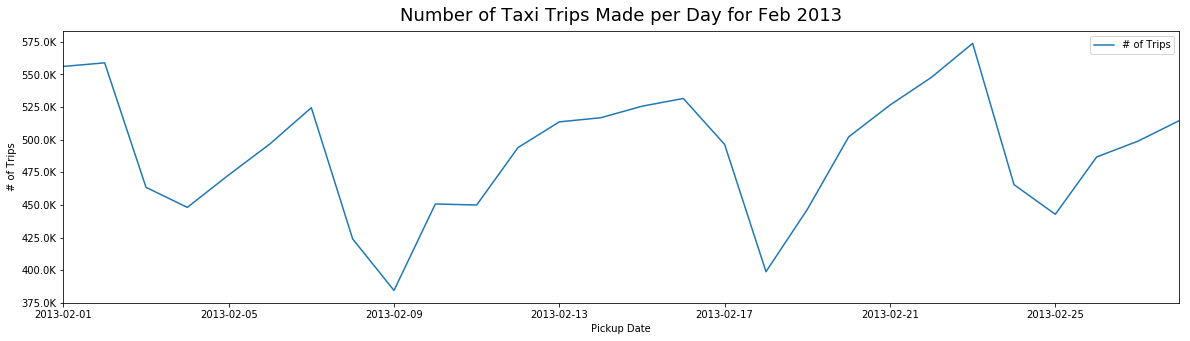

In [45]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of Taxi Trips Made per Day for ' + dt, title_font)

visDataTrips.plot(kind='line', x="Pickup Date", y="# of Trips", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='# of Trips')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

In [46]:
ax.get_ylim()[1] /10

58319.840000000004

## Number of Passengers

In [47]:
# Calc the number of passengers moved per day
visDataPassenger = tripDataFare.groupby(['pickup_date'], as_index=False)['passenger_count'].agg('sum')
# sort the dates
visDataPassenger = visDataPassenger.sort_values(by=['pickup_date'])
visDataPassenger.columns = ['Pickup Date', '# of Passengers']
visDataPassenger.head()

Pickup Date  # of Passengers
0  2013-02-01           940624
1  2013-02-02           991654
2  2013-02-03           807214
3  2013-02-04           738381
4  2013-02-05           777032

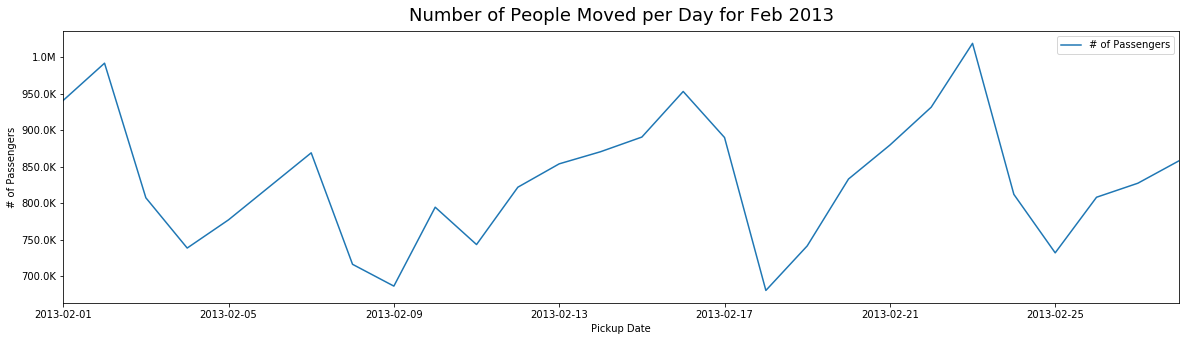

In [48]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of People Moved per Day for ' + dt, title_font)

visDataPassenger.plot(kind='line', x="Pickup Date", y="# of Passengers", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='# of Passengers')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

## Revenue

### Fare Revenue Only

In [49]:
# Calc the number of passengers moved per day
visDataFareRevenue = tripDataFare.groupby(['pickup_date'], as_index=False)['fare_amount'].agg('sum')
# sort the dates
visDataFareRevenue = visDataFareRevenue.sort_values(by=['pickup_date'])
visDataFareRevenue.columns = ['Pickup Date', 'Fare Revenue']
visDataFareRevenue.head()

Pickup Date  Fare Revenue
0  2013-02-01    6566189.21
1  2013-02-02    6214716.11
2  2013-02-03    5389462.04
3  2013-02-04    5229992.53
4  2013-02-05    5437215.96

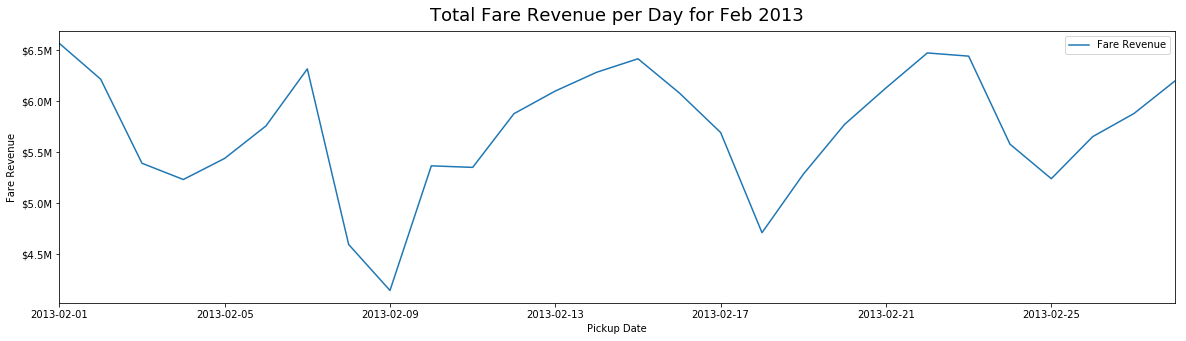

In [50]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Total Fare Revenue per Day for ' + dt, title_font)

visDataFareRevenue.plot(kind='line', x="Pickup Date", y="Fare Revenue", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Fare Revenue')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

### Total Revenue

In [51]:
# Calc the number of passengers moved per day
visDataRevenue = tripDataFare.groupby(['pickup_date'], as_index=False)['total_amount'].agg('sum')
# sort the dates
visDataRevenue = visDataRevenue.sort_values(by=['pickup_date'])
visDataRevenue.columns = ['Pickup Date', 'Total Revenue']
visDataRevenue.head()

Pickup Date  Total Revenue
0  2013-02-01   7.898957e+06
1  2013-02-02   7.320037e+06
2  2013-02-03   6.384067e+06
3  2013-02-04   6.323118e+06
4  2013-02-05   6.575208e+06

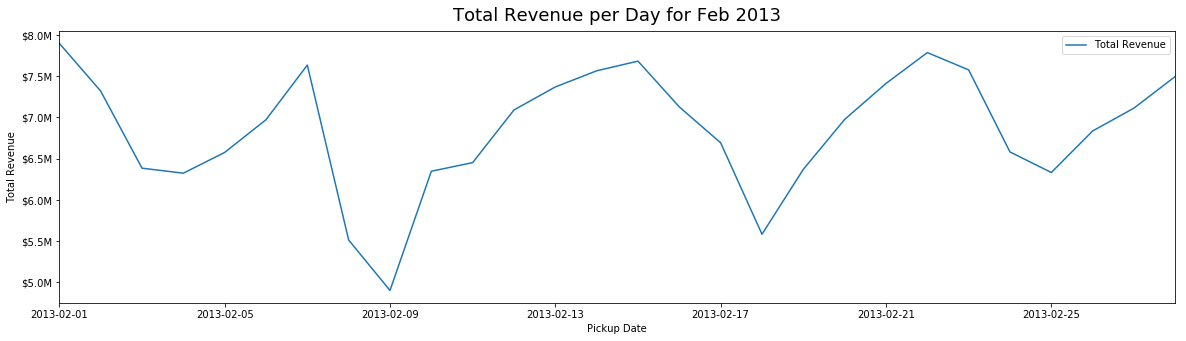

In [52]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Total Revenue per Day for ' + dt, title_font)

visDataRevenue.plot(kind='line', x="Pickup Date", y="Total Revenue", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Total Revenue')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

# Combined

## Fare and Total Fare Revenue

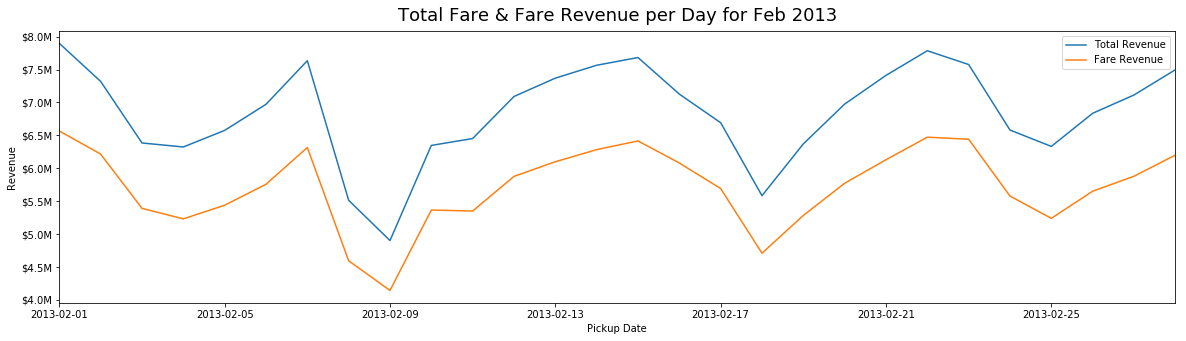

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Total Fare & Fare Revenue per Day for ' + dt, title_font)

visDataRevenue.plot(kind='line', x="Pickup Date", y="Total Revenue", ax=ax)
visDataFareRevenue.plot(kind='line', x="Pickup Date", y="Fare Revenue", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Revenue')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10 , "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10 , "New Years Day")

plt.show()

## Trips and Passengers

## Trips and Passengers

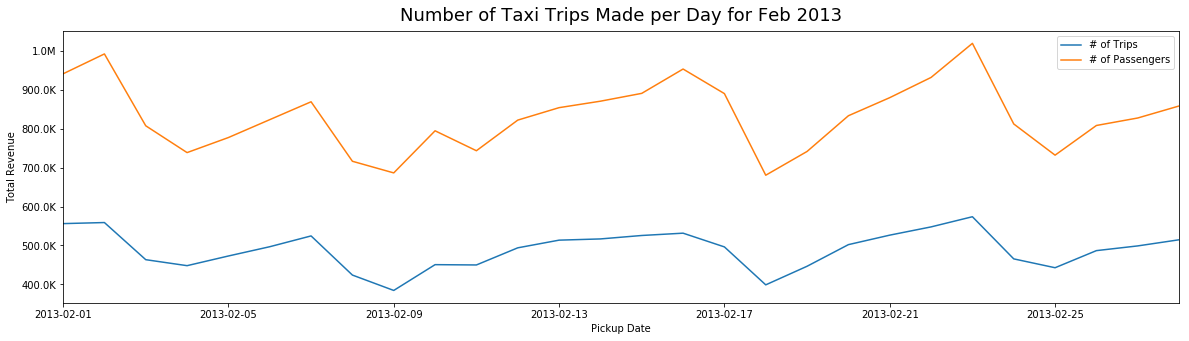

In [54]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of Taxi Trips Made per Day for ' + dt, title_font)

visDataTrips.plot(kind='line', x="Pickup Date", y="# of Trips", ax=ax)
visDataPassenger.plot(kind='line', x="Pickup Date", y="# of Passengers", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Total Revenue')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

# Scatter

## # of Trips & # of Passengers

In [55]:
visDataTripsPassengers = pd.merge(visDataTrips, visDataPassenger, how='left', left_on = ['Pickup Date'], right_on = ['Pickup Date'])
visDataTripsPassengers.head()


Pickup Date  # of Trips  # of Passengers
0  2013-02-01      556064           940624
1  2013-02-02      558809           991654
2  2013-02-03      463490           807214
3  2013-02-04      448116           738381
4  2013-02-05      472958           777032

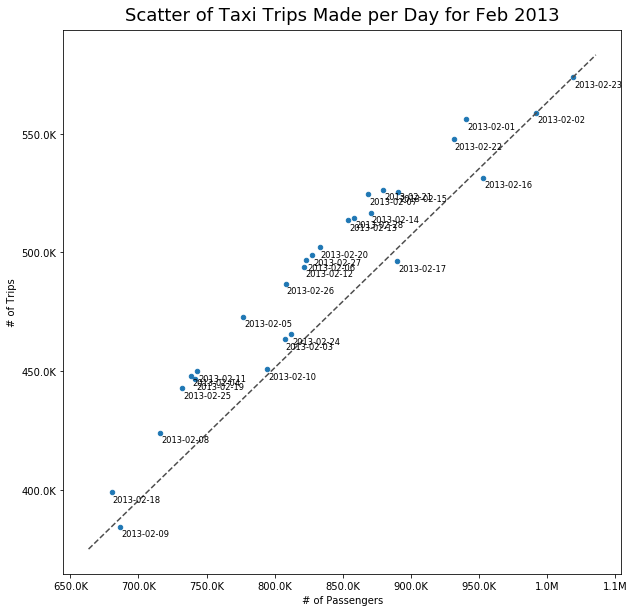

In [56]:
#plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Scatter of Taxi Trips Made per Day for ' + dt, title_font)

visDataTripsPassengers.plot(kind='scatter', x='# of Passengers', y='# of Trips',  s=20, ax=ax)

for line in range(0,visDataTripsPassengers.shape[0]):
    ax.text(visDataTripsPassengers['# of Passengers'][line]+900, visDataTripsPassengers['# of Trips'][line]-4000, \
             visDataTripsPassengers['Pickup Date'][line], horizontalalignment='left', size='small', color='black')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

## Total Fare Revenue & # of Trips

In [57]:
visDataTripsPassengersRevenue = pd.merge(visDataTripsPassengers, visDataRevenue, how='left', left_on = ['Pickup Date'], right_on = ['Pickup Date'])
visDataTripsPassengersRevenue.head()

Pickup Date  # of Trips  # of Passengers  Total Revenue
0  2013-02-01      556064           940624   7.898957e+06
1  2013-02-02      558809           991654   7.320037e+06
2  2013-02-03      463490           807214   6.384067e+06
3  2013-02-04      448116           738381   6.323118e+06
4  2013-02-05      472958           777032   6.575208e+06

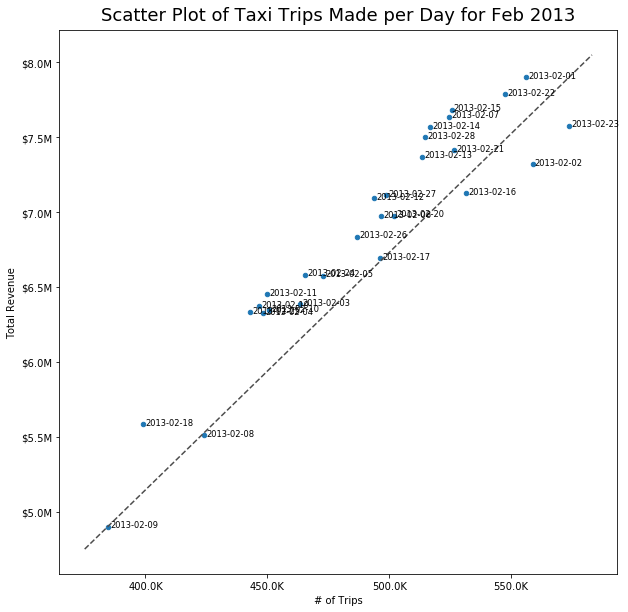

In [58]:
#plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Scatter Plot of Taxi Trips Made per Day for ' + dt, title_font)

visDataTripsPassengersRevenue.plot(kind='scatter', x='# of Trips', y='Total Revenue', s=20 , ax=ax)

for line in range(0,visDataTripsPassengers.shape[0]):
    ax.text(visDataTripsPassengersRevenue['# of Trips'][line]+900, visDataTripsPassengersRevenue['Total Revenue'][line]-4000, \
             visDataTripsPassengersRevenue['Pickup Date'][line], horizontalalignment='left', size='small', color='black')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

## Total Fare Revenue & Fare Revenue

In [59]:
visDataTripsPassengersRevenueFareRevenue = pd.merge(visDataTripsPassengersRevenue, visDataFareRevenue, how='left', left_on = ['Pickup Date'], right_on = ['Pickup Date'])
visDataTripsPassengersRevenueFareRevenue.head()

Pickup Date  # of Trips  # of Passengers  Total Revenue  Fare Revenue
0  2013-02-01      556064           940624   7.898957e+06    6566189.21
1  2013-02-02      558809           991654   7.320037e+06    6214716.11
2  2013-02-03      463490           807214   6.384067e+06    5389462.04
3  2013-02-04      448116           738381   6.323118e+06    5229992.53
4  2013-02-05      472958           777032   6.575208e+06    5437215.96

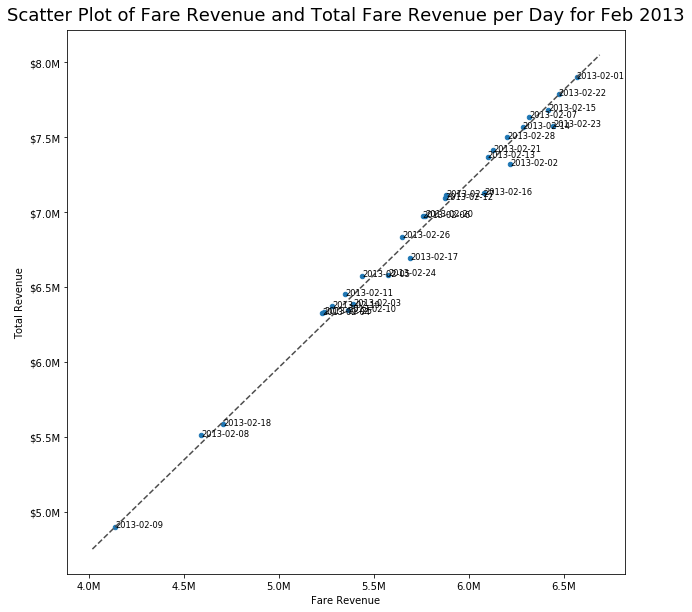

In [60]:
#plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Scatter Plot of Fare Revenue and Total Fare Revenue per Day for ' + dt, title_font)

visDataTripsPassengersRevenueFareRevenue.plot(kind='scatter', x='Fare Revenue', y='Total Revenue', s=20 , ax=ax)

for line in range(0,visDataTripsPassengers.shape[0]):
    ax.text(visDataTripsPassengersRevenueFareRevenue['Fare Revenue'][line]+900, visDataTripsPassengersRevenueFareRevenue['Total Revenue'][line]-4000, \
             visDataTripsPassengersRevenueFareRevenue['Pickup Date'][line], horizontalalignment='left', size='small', color='black')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

# Question 2


# Visualising the busiest hours

source: https://chih-ling-hsu.github.io/2018/05/14/NYC

In [61]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

## Getting the data into the correct format

In [62]:
def tripVis (tripLengthBoundary = 10):
    visData = tripDataFare[['pickup_hour', 'dropoff_hour']][tripDataFare['trip_distance'] < tripLengthBoundary] 
    visData['count'] = 1
    df_q3_short = visData.groupby(['pickup_hour', 'dropoff_hour'],as_index=False).count()
    df_q3_short.columns = ['PUtime', 'DOtime', 'count']
    #df_q3_short.head()
    visData = tripDataFare[['pickup_hour', 'dropoff_hour']][tripDataFare['trip_distance'] >= tripLengthBoundary] 
    visData['count'] = 1
    df_q3_long = visData.groupby(['pickup_hour', 'dropoff_hour'],as_index=False).count()
    df_q3_long.columns = ['PUtime', 'DOtime', 'count']
    #df_q3_long.head()
    df_q3 = df_q3_short.merge(df_q3_long, how='left', on=["PUtime", "DOtime"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips", \
                                        "PUtime":"pickup time", "DOtime":"dropoff time"})
    #create pickup time dataframe
    df_q3_PU = df_q3.groupby(["pickup time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="pickup time")
    #df_q3_PU.head()
    #create dropoff time dataframe
    df_q3_DO = df_q3.groupby(["dropoff time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="dropoff time")
    #df_q3_DO.head()
    # diff_short_long_trip_on_time()
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

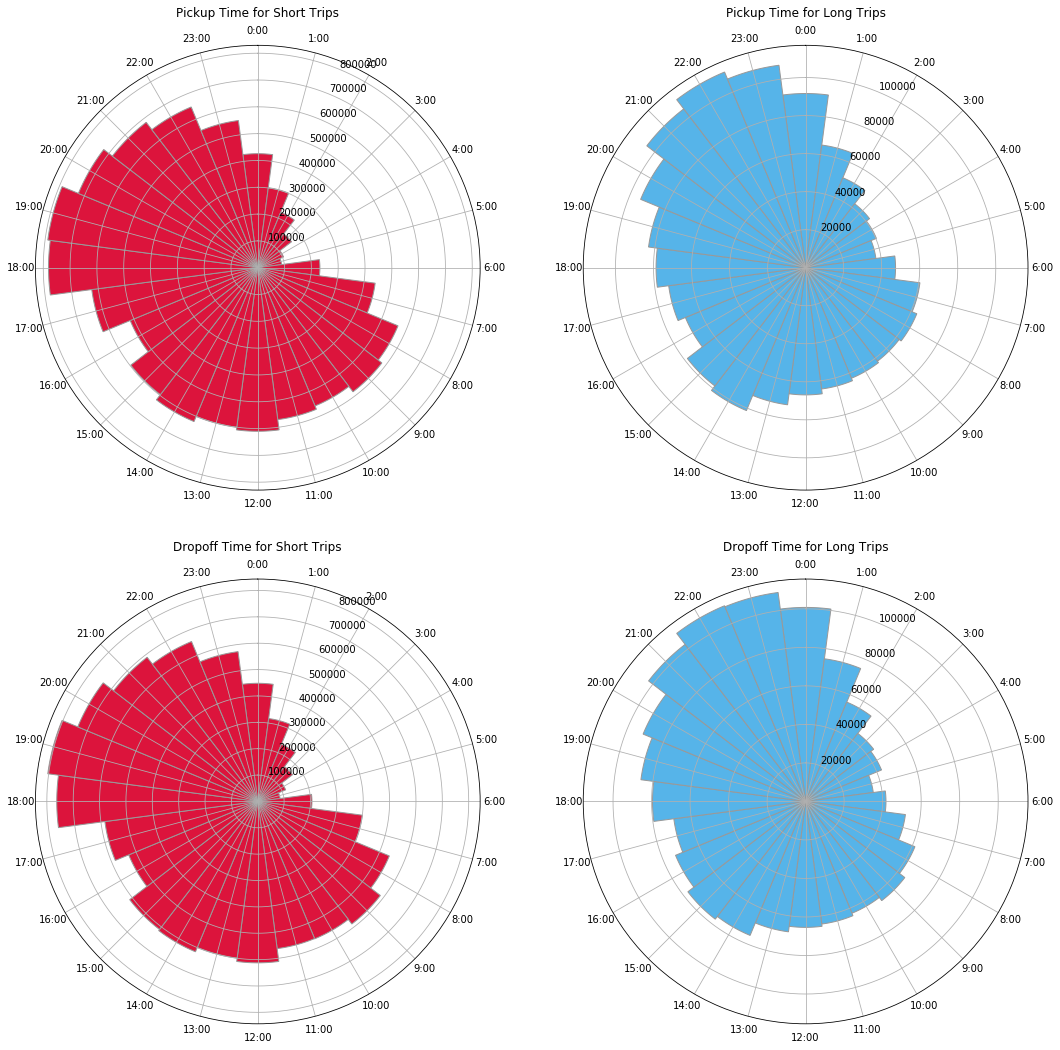

In [63]:
tripVis(5)


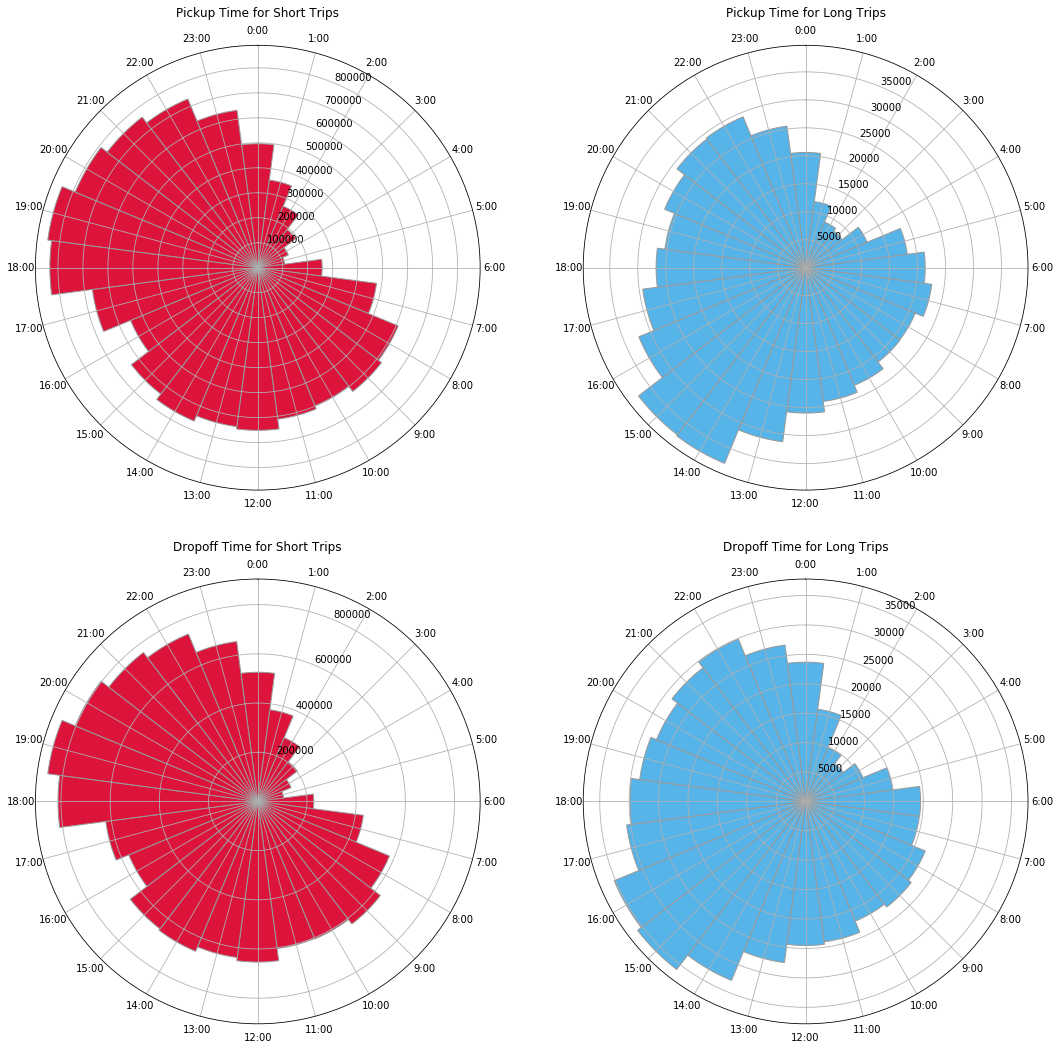

In [64]:
tripVis(10)

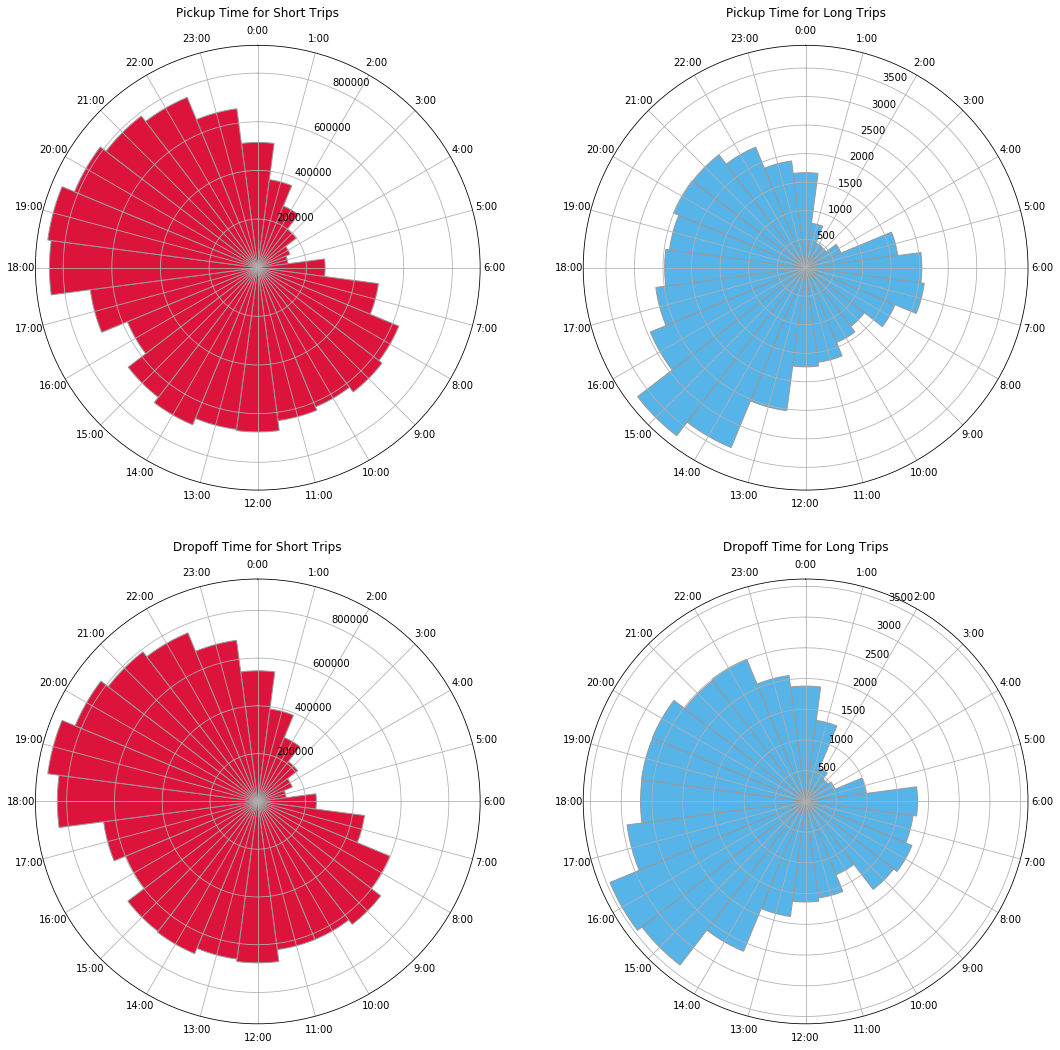

In [65]:
tripVis(20)

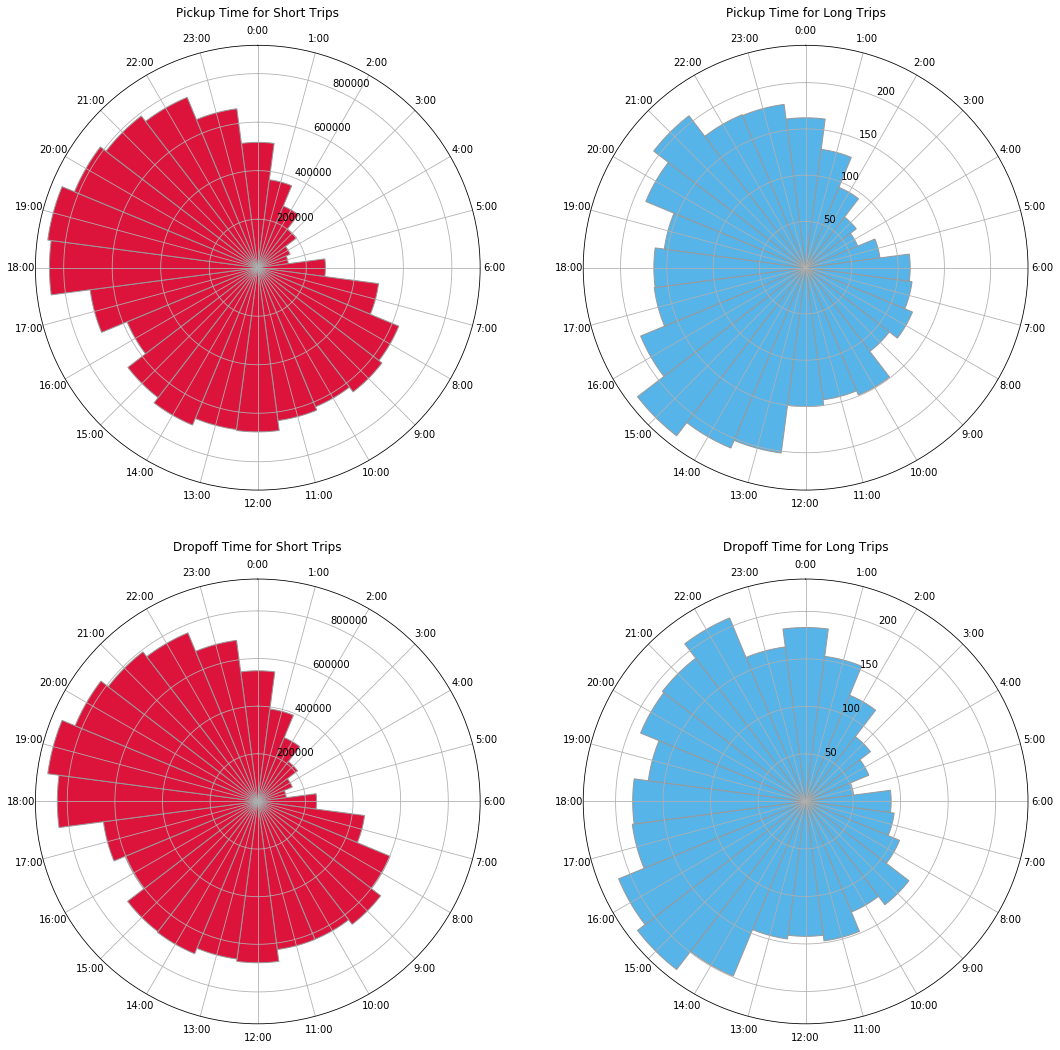

In [66]:
tripVis(30)

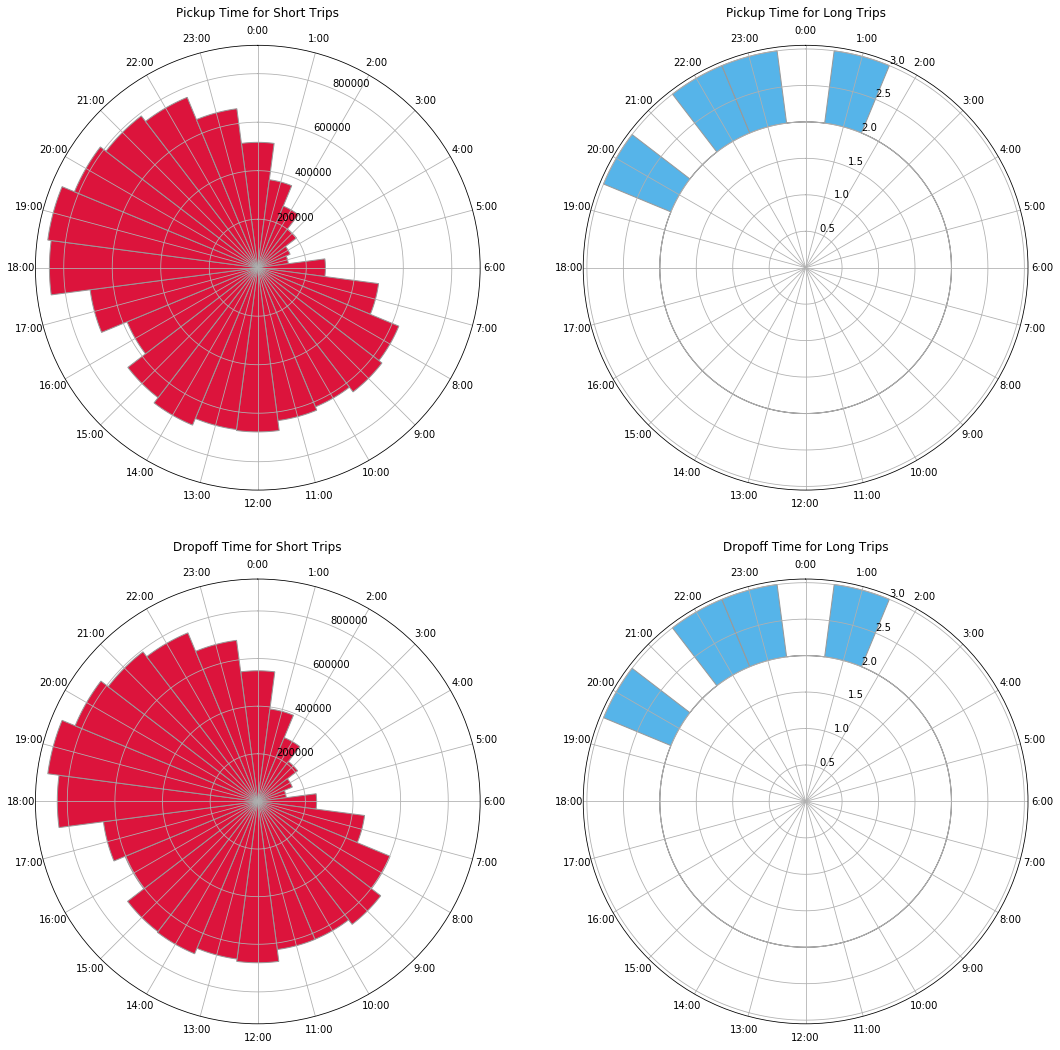

In [67]:
tripVis(100)

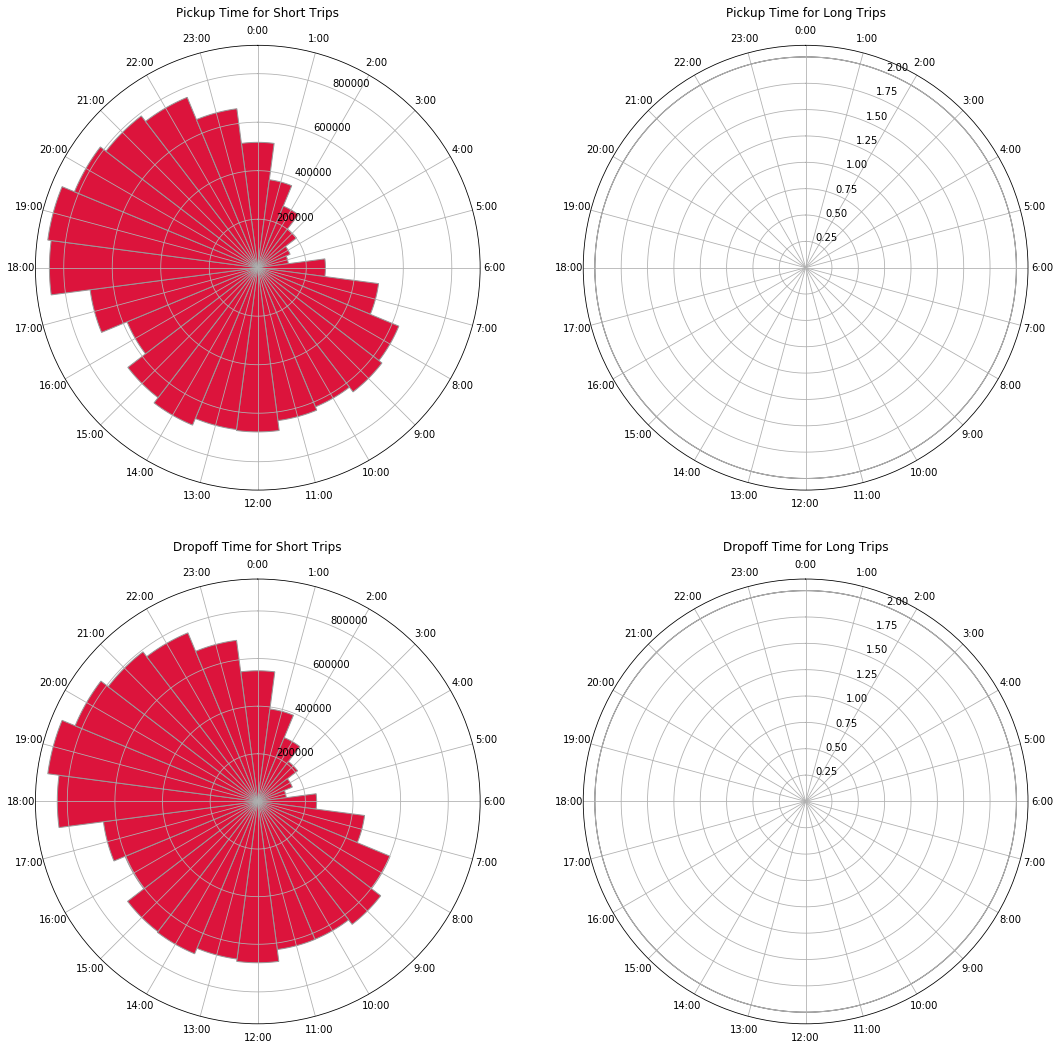

In [68]:
tripVis(200)

In [69]:
del  tripVis

gc.collect()

40732

# Question 3

How are Passengers per trip, payment type, fare and tip amounts distributed?


## Reporting axis ordering section

In [70]:
def retOrderMapping(field):
    if field == 'tripLength':
            return tripLengthOrderMapping
    elif field == 'tripDuration':
        return tripDurationMapping
    elif field == 'pickup_weekdayWeekend':
        return weekdayWeekendMapping
    elif field == 'pickup_dayName':
        return dayNameMapping
    elif field == 'vendor_id':
        return vendor_idOrderMapping
    elif field == 'payment_type':
        return payment_typeOrderMapping  
    elif field == 'Taxi Use':
        return taxiUseOrderMapping  
    elif field == 'pickup_timeOfDay':
        return pickup_timeOfDayOrderMapping

In [71]:
tripLengthOrder = ['up to 1 mile', '1 to 5 miles', '6 to 10 miles', '10 to 20 miles', '20 + miles', 'Error']
# this creates some value key pairs in the correct order
tripLengthOrderMapping = {trip: i for i, trip in enumerate(tripLengthOrder)}
del tripLengthOrder

In [72]:
payment_typeOrder = ['CSH', 'CRD', 'DIS', 'NOC',  'UNK']
# this creates some value key pairs in the correct order
payment_typeOrderMapping = {trip: i for i, trip in enumerate(payment_typeOrder)}
del payment_typeOrder

In [73]:
vendor_idOrder = ['CMT', 'VTS']
# this creates some value key pairs in the correct order
vendor_idOrderMapping = {trip: i for i, trip in enumerate(vendor_idOrder)}
del vendor_idOrder

In [74]:
taxiUseOrder = ['Single Use', 'Low', 'Medium', 'High', 'Extreme', 'Error']
# this creates some value key pairs in the correct order
taxiUseOrderMapping = {trip: i for i, trip in enumerate(taxiUseOrder)}
del taxiUseOrder

In [75]:
pickup_timeOfDayOrder = ['Morning Rush Hour', 'Late morning', 'Early afternoon', 'Evening Rush Hour', 'Evening', 'Night', 'Error' ]
# this creates some value key pairs in the correct order
pickup_timeOfDayOrderMapping = {trip: i for i, trip in enumerate(pickup_timeOfDayOrder)}
del pickup_timeOfDayOrder

In [76]:
weekdayWeekend = ['Weekday', 'Weekend']
# this creates some value key pairs in the correct order
weekdayWeekendMapping = {trip: i for i, trip in enumerate(weekdayWeekend)}
del weekdayWeekend

In [77]:
tripDuration = ['up to 5 minutes', '5 to 10 minutes', '10 to 15 minutes', '15 to 20 minutes', '20 + minutes', 'Error']
# this creates some value key pairs in the correct order
tripDurationMapping = {trip: i for i, trip in enumerate(tripDuration)}
del tripDuration

In [78]:
dayName = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# this creates some value key pairs in the correct order
dayNameMapping = {trip: i for i, trip in enumerate(dayName)}
del dayName

In [79]:
# free memory
gc.collect()

80

In [80]:
# create a df to use for visualising
visDataQ3 = tripDataFare[['pickup_date','passenger_count', 'trip_distance', 'rate_code',
       'store_and_fwd_flag', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'pickup_dayName', 'pickup_weekdayWeekend', 'tripLength',
       'tripDuration']]
visDataQ3.head()

pickup_date  passenger_count  trip_distance  rate_code store_and_fwd_flag  \
0  2013-02-08                1            0.8          1                  N   
1  2013-02-07                4            3.1          1                  N   
2  2013-02-08                1            1.0          1                  N   
3  2013-02-08                1            2.1          1                  N   
4  2013-02-08                1            3.3          1                  N   

  payment_type  fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  \
0          CRD          6.0        0.5      0.5         0.0           0.0   
1          CRD         20.0        0.0      0.5         3.0           0.0   
2          CRD          5.0        0.0      0.5         1.1           0.0   
3          CRD         11.0        0.0      0.5         2.3           0.0   
4          CRD         13.0        1.0      0.5         1.5           0.0   

   total_amount pickup_dayName pickup_weekdayWeekend    tripLength  \
0           7.0         Friday               Weekday  up to 1 mile   
1          23.5       Thursday               Weekday  1 to 5 miles   
2           6.6         Friday               Weekday  up to 1 mile   
3          13.8         Friday               Weekday  1 to 5 miles   
4          16.0         Friday               Weekday  1 to 5 miles   

       tripDuration  
0   5 to 10 minutes  
1      20 + minutes  
2   up to 5 minutes  
3  10 to 15 minutes  
4  10 to 15 minutes

## Visualisation Section

### Passenger Count by Trip Length

In [81]:
# define which order we are using

orderMapping = tripLengthOrderMapping

In [82]:
byField = 'tripLength'
countField = 'passenger_count'


# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3.head()

tripLength  passenger_count
0    1 to 5 miles         14707424
1  10 to 20 miles           904498
2      20 + miles           765430
3   6 to 10 miles          1237280
4           Error            67937

In [83]:
# create the sort key
key = visQ3[byField].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripLength  passenger_count
5    up to 1 mile          5603985
0    1 to 5 miles         14707424
3   6 to 10 miles          1237280
1  10 to 20 miles           904498
2      20 + miles           765430

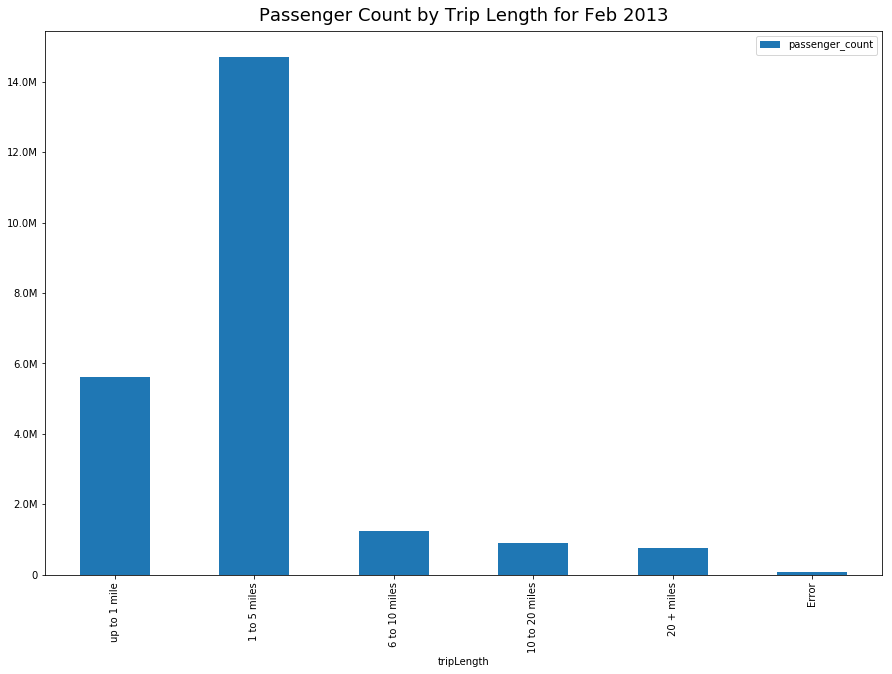

In [84]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Passenger Count by Trip Length for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

### Total Revenue by Trip Length

In [85]:
# define which order we are using
orderMapping = tripLengthOrderMapping

In [86]:
byField = 'tripLength'
countField = 'total_amount'


# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3.head()

tripLength  total_amount
0    1 to 5 miles  1.066676e+08
1  10 to 20 miles  2.622390e+07
2      20 + miles  1.230777e+07
3   6 to 10 miles  2.189784e+07
4           Error  1.364717e+06

In [87]:
# create the sort key
key = visQ3[byField].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripLength  total_amount
5    up to 1 mile  2.344992e+07
0    1 to 5 miles  1.066676e+08
3   6 to 10 miles  2.189784e+07
1  10 to 20 miles  2.622390e+07
2      20 + miles  1.230777e+07

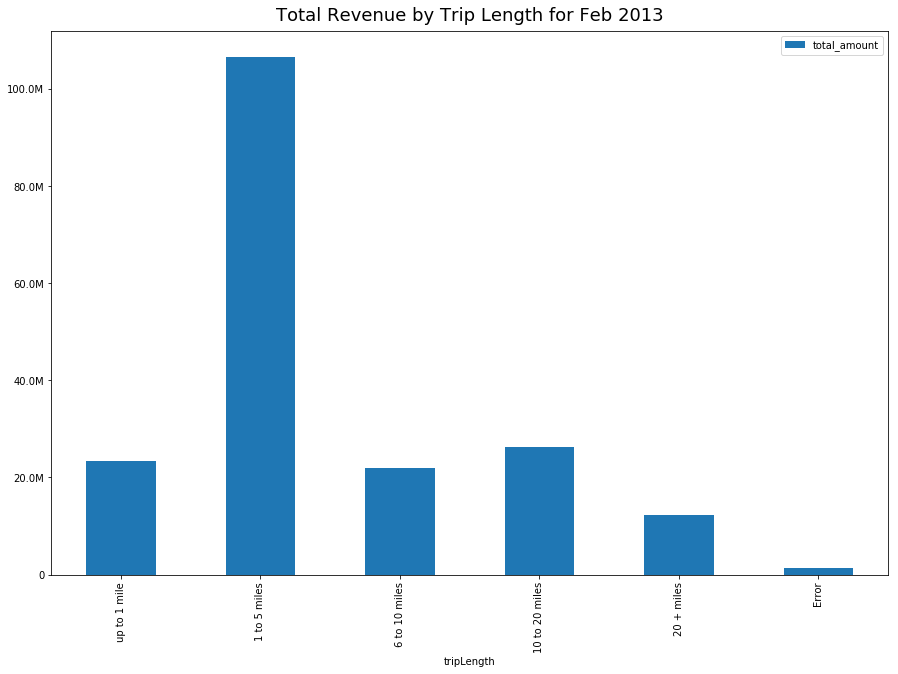

In [88]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Total Revenue by Trip Length for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

### Passenger Count by Trip Duration

In [89]:
# define which order we are using
orderMapping = tripDurationMapping

In [90]:
byField = 'tripDuration'
countField = 'passenger_count'

# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3

tripDuration  passenger_count
0  10 to 15 minutes          5107612
1  15 to 20 minutes          2787226
2      20 + minutes          2974379
3   5 to 10 minutes          7807776
4             Error            15676
5   up to 5 minutes          4593885

In [91]:
visQ3['tripDuration']

0    10 to 15 minutes
1    15 to 20 minutes
2        20 + minutes
3     5 to 10 minutes
4               Error
5     up to 5 minutes
Name: tripDuration, dtype: object

In [92]:
# create the sort key
key = visQ3['tripDuration'].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripDuration  passenger_count
5   up to 5 minutes          4593885
3   5 to 10 minutes          7807776
0  10 to 15 minutes          5107612
1  15 to 20 minutes          2787226
2      20 + minutes          2974379

NameError: name 'visQ3' is not defined

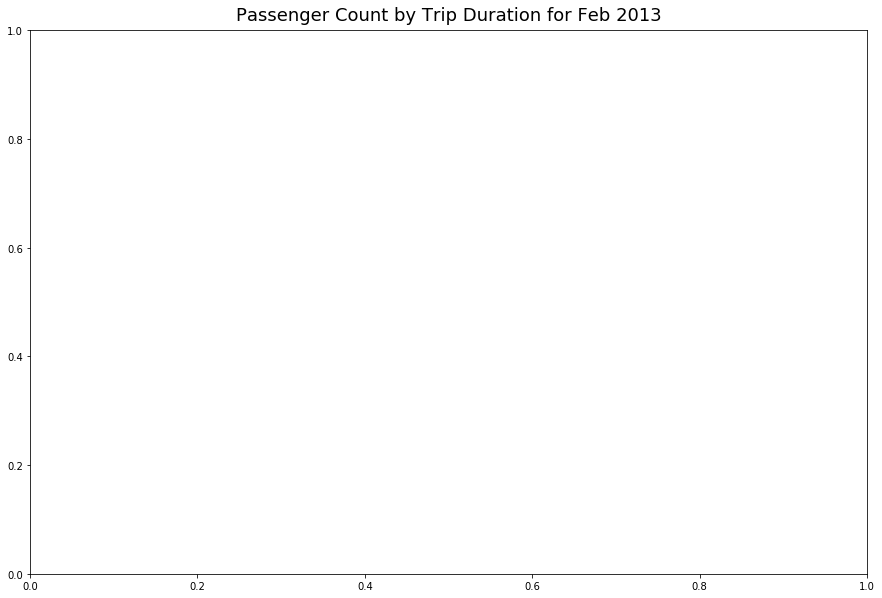

In [137]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Passenger Count by Trip Duration for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

### Total Revenue by Trip Duration

In [94]:
# define which order we are using
orderMapping = tripDurationMapping

In [95]:
byField = 'tripDuration'
countField = 'total_amount'

# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3

tripDuration  total_amount
0  10 to 15 minutes  4.119815e+07
1  15 to 20 minutes  3.130196e+07
2      20 + minutes  5.843960e+07
3   5 to 10 minutes  4.306055e+07
4             Error  1.533929e+05
5   up to 5 minutes  1.775807e+07

In [96]:
# create the sort key
key = visQ3['tripDuration'].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripDuration  total_amount
5   up to 5 minutes  1.775807e+07
3   5 to 10 minutes  4.306055e+07
0  10 to 15 minutes  4.119815e+07
1  15 to 20 minutes  3.130196e+07
2      20 + minutes  5.843960e+07

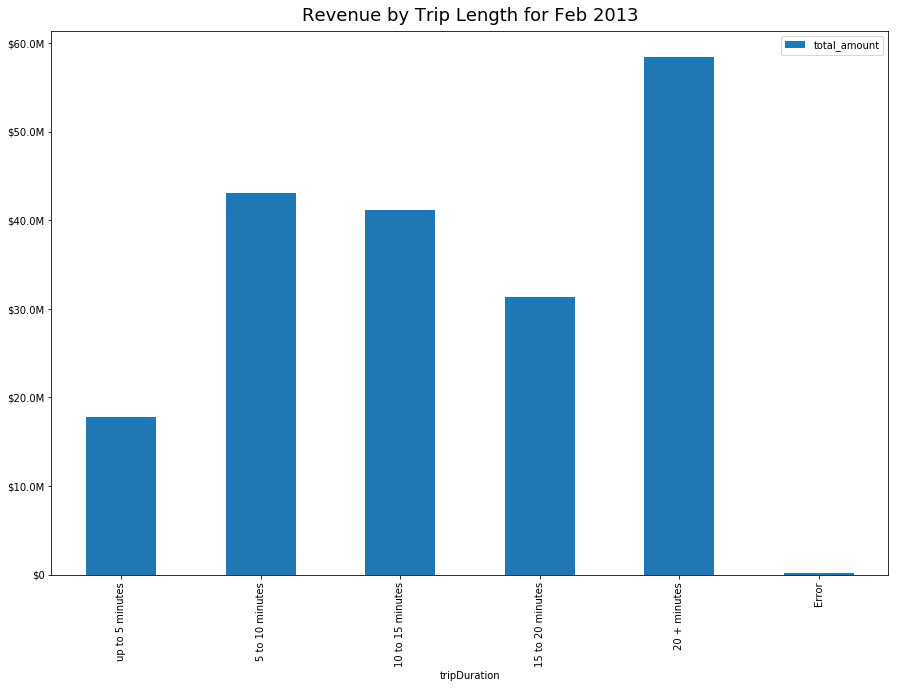

In [97]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Revenue by Trip Duration for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

plt.show()

## Day of the Week

In [98]:
# define which order we are using
orderMapping = tripDurationMapping

In [99]:
byField = 'pickup_dayName'
countField = 'total_amount'

# Calc the number of journeys per day
visQ3 = tripDataFare[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3

pickup_dayName  total_amount
0         Friday  2.888153e+07
1         Monday  2.468878e+07
2       Saturday  2.692451e+07
3         Sunday  2.600333e+07
4       Thursday  3.011078e+07
5        Tuesday  2.687169e+07
6      Wednesday  2.843110e+07

In [100]:
# create the sort key
key = visQ3[byField].map(retOrderMapping(byField)) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

pickup_dayName  total_amount
1         Monday  2.468878e+07
5        Tuesday  2.687169e+07
6      Wednesday  2.843110e+07
4       Thursday  3.011078e+07
0         Friday  2.888153e+07

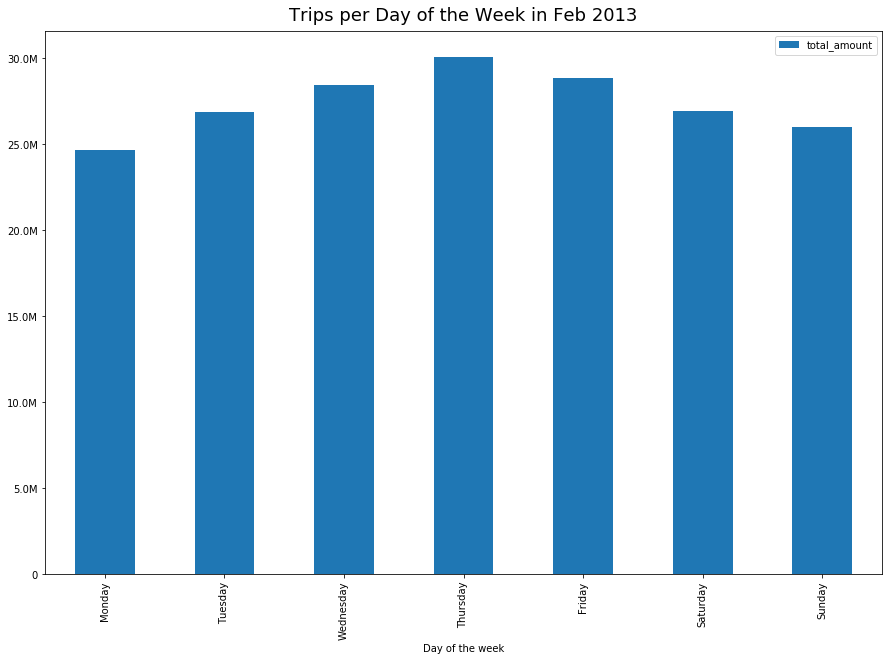

In [101]:

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Trips per Day of the Week in ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)
ax.set_xlabel("Day of the week")

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

In [102]:
#clean up
del visDataQ3, visQ3

gc.collect()

13605

# Drivers

In [103]:
def taxiUse(i):
    # look at the number of taxis they use and categorise on that
    if i <= 0:  # catches 0 and neg numbers as errors
        result = "Error"
    elif i > 0 and i <= 1:
        result = "Single Use"
    elif i > 1 and i <= 5:
        result = "Low"
    elif i > 6 and i <= 10:
        result = "Medium"
    elif i > 10 and i <= 20:
        result = "High"
    else:
        result = "Extreme"
    return result

In [104]:
driverVehicle = tripDataFare[['medallion', 'hack_license', 'fare_amount', 'tip_amount', 'total_amount', 'trip_time_in_secs']]
driverVehicle['count'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
#driverVehicle.groupby(['medallion', 'hack_license']).agg('sum')

In [106]:
# filter out some rows for testing code
filter = ['00567B1CBFD51DDFAC73359B09238922', '0002555BBE359440D6CEB34B699D3932', '00B7691D86D96AEBD21DD9E138F90840']
#driverVehicle[driverVehicle['hack_license'].isin(filter)].groupby(['hack_license', 'medallion']).agg('count')

In [107]:
# filter out some rows for testing code
#driverVehicle[['hack_license', 'medallion']][driverVehicle['hack_license'].isin(filter)].groupby(['hack_license'])['medallion'].nunique()

In [108]:
#driverVehicle[driverVehicle['hack_license'].isin(filter)].groupby(['hack_license', 'medallion'], as_index=False).agg('sum')

In [109]:
driverTaxiJourneys = driverVehicle.groupby(['hack_license', 'medallion'], as_index=False).agg('sum')
driverTaxiJourneys.head()

hack_license                         medallion  \
0  0002555BBE359440D6CEB34B699D3932  BE530E79CB7E459DEF5BBDF2F319EDC1   
1  0008B3E338CE8C3377E071A4D80D3694  635E404F9572621472751B82C86724FB   
2  0008B3E338CE8C3377E071A4D80D3694  6F80CA4A5DD2F0536A1D4F43671F74EA   
3  0008B3E338CE8C3377E071A4D80D3694  757AF98FB61CD1EF22A61A87084524DB   
4  0008B3E338CE8C3377E071A4D80D3694  8FA6FBF2D595A1080BCCE03FC2C213F7   

   fare_amount  tip_amount  total_amount  trip_time_in_secs  count  
0       7336.5      868.20       9018.90             429580    517  
1        234.5       21.40        279.20              14677     16  
2        253.0       31.26        310.06              13851     23  
3        109.5       13.20        138.00               5677      9  
4       3664.5      396.62       4431.72             219720    303

In [110]:
driverTaxiJourneys.columns = ['Driver', 'Taxi', 'Fare Amount', 'Tip Amount', 'Total Amount', 'Trip Time (sec)', 'Trip Count',]

In [111]:
# calculate the number of taxis jounreys used by a driver in the data (in this case a month)
# output of value counts is a series so need to convert to frame and then reset the index to bring the driver into a column
driverInfo = driverTaxiJourneys['Driver'].value_counts().to_frame().reset_index()
driverInfo.columns = ['Driver', '# of Taxis']
driverInfo.head()

Driver  # of Taxis
0  00B7691D86D96AEBD21DD9E138F90840         300
1  AF21D0C97DB2E27E13572CBF59EB343D         164
2  C1059E614E05082428C20540004D03CE         148
3  B59C67BF196A4758191E42F76670CEBA         132
4  C667D53ACD899A97A85DE0C201BA99BE         110

In [112]:
# add in the total number of trips the driver has made this month
# this is done inline
driverInfo = pd.merge(driverInfo, \
                      driverTaxiJourneys.groupby(['Driver'], as_index=False).agg(["sum", "mean"]), \
                      how='left', \
                      left_on = ['Driver'], \
                      right_on = ['Driver'] )
driverInfo.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Driver  # of Taxis  (Fare Amount, sum)  \
0  00B7691D86D96AEBD21DD9E138F90840         300              3356.0   
1  AF21D0C97DB2E27E13572CBF59EB343D         164               748.4   
2  C1059E614E05082428C20540004D03CE         148               755.8   
3  B59C67BF196A4758191E42F76670CEBA         132               701.9   
4  C667D53ACD899A97A85DE0C201BA99BE         110               587.3   

   (Fare Amount, mean)  (Tip Amount, sum)  (Tip Amount, mean)  \
0            11.186667              38.45            0.128167   
1             4.563415              11.30            0.068902   
2             5.106757               0.00            0.000000   
3             5.317424               0.00            0.000000   
4             5.339091               0.00            0.000000   

   (Total Amount, sum)  (Total Amount, mean)  (Trip Time (sec), sum)  \
0              3858.25             12.860833                  183600   
1               881.95              5.377744                   20854   
2               871.30              5.887162                   28925   
3               861.15              6.523864                   15274   
4               665.80              6.052727                   15352   

   (Trip Time (sec), mean)  (Trip Count, sum)  (Trip Count, mean)  
0               612.000000                652            2.173333  
1               127.158537                213            1.298780  
2               195.439189                223            1.506757  
3               115.712121                187            1.416667  
4               139.563636                152            1.381818

In [113]:
driverInfo.columns = ['Driver', '# of Taxis', 'Fare Amount (sum)', 'Fare Amount (mean)', 'Tip Amount (sum)', 'Tip Amount (mean)', 'Total Amount (sum)', 'Total Amount (mean)', 'Trip Time (sec) (sum)', 'Trip Time (sec) (mean)', 'Trip Count (sum)','Trip Count (mean)']

In [114]:
driverInfo['Trips Per Taxi'] = driverInfo['Trip Count (sum)'] / driverInfo['# of Taxis']
driverInfo['Fare Per Trip'] = driverInfo['Fare Amount (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Tip Per Trip'] = driverInfo['Tip Amount (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Amount Per Trip'] = driverInfo['Total Amount (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Journey Time (sec) Per Trip'] = driverInfo['Trip Time (sec) (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Journey Time (mins) Per Trip'] = (driverInfo['Trip Time (sec) (sum)']/60) / driverInfo['Trip Count (sum)']
driverInfo['Trip Time (mins) (sum)'] = (driverInfo['Trip Time (sec) (sum)']/60)
driverInfo['Trip Time (hrs) (sum)'] = (driverInfo['Trip Time (sec) (sum)']/3600)
driverInfo['Trip Time (mins) (mean)'] = (driverInfo['Trip Time (sec) (mean)']/60)
driverInfo.head()

Driver  # of Taxis  Fare Amount (sum)  \
0  00B7691D86D96AEBD21DD9E138F90840         300             3356.0   
1  AF21D0C97DB2E27E13572CBF59EB343D         164              748.4   
2  C1059E614E05082428C20540004D03CE         148              755.8   
3  B59C67BF196A4758191E42F76670CEBA         132              701.9   
4  C667D53ACD899A97A85DE0C201BA99BE         110              587.3   

   Fare Amount (mean)  Tip Amount (sum)  Tip Amount (mean)  \
0           11.186667             38.45           0.128167   
1            4.563415             11.30           0.068902   
2            5.106757              0.00           0.000000   
3            5.317424              0.00           0.000000   
4            5.339091              0.00           0.000000   

   Total Amount (sum)  Total Amount (mean)  Trip Time (sec) (sum)  \
0             3858.25            12.860833                 183600   
1              881.95             5.377744                  20854   
2              871.30             5.887162                  28925   
3              861.15             6.523864                  15274   
4              665.80             6.052727                  15352   

   Trip Time (sec) (mean)  Trip Count (sum)  Trip Count (mean)  \
0              612.000000               652           2.173333   
1              127.158537               213           1.298780   
2              195.439189               223           1.506757   
3              115.712121               187           1.416667   
4              139.563636               152           1.381818   

   Trips Per Taxi  Fare Per Trip  Tip Per Trip  Amount Per Trip  \
0        2.173333       5.147239      0.058972         5.917561   
1        1.298780       3.513615      0.053052         4.140610   
2        1.506757       3.389238      0.000000         3.907175   
3        1.416667       3.753476      0.000000         4.605080   
4        1.381818       3.863816      0.000000         4.380263   

   Journey Time (sec) Per Trip  Journey Time (mins) Per Trip  \
0                   281.595092                      4.693252   
1                    97.906103                      1.631768   
2                   129.708520                      2.161809   
3                    81.679144                      1.361319   
4                   101.000000                      1.683333   

   Trip Time (mins) (sum)  Trip Time (hrs) (sum)  Trip Time (mins) (mean)  
0             3060.000000              51.000000                10.200000  
1              347.566667               5.792778                 2.119309  
2              482.083333               8.034722                 3.257320  
3              254.566667               4.242778                 1.928535  
4              255.866667               4.264444                 2.326061

Code to view the counts 
from collections import Counter
hist = Counter(driverInfo['# of Taxis'])


In [115]:
# # look at the number of taxis they use and categorise on that
driverInfo['Taxi Use'] = driverInfo["# of Taxis"].map(lambda x: taxiUse(x))

## Plotting - Driver info

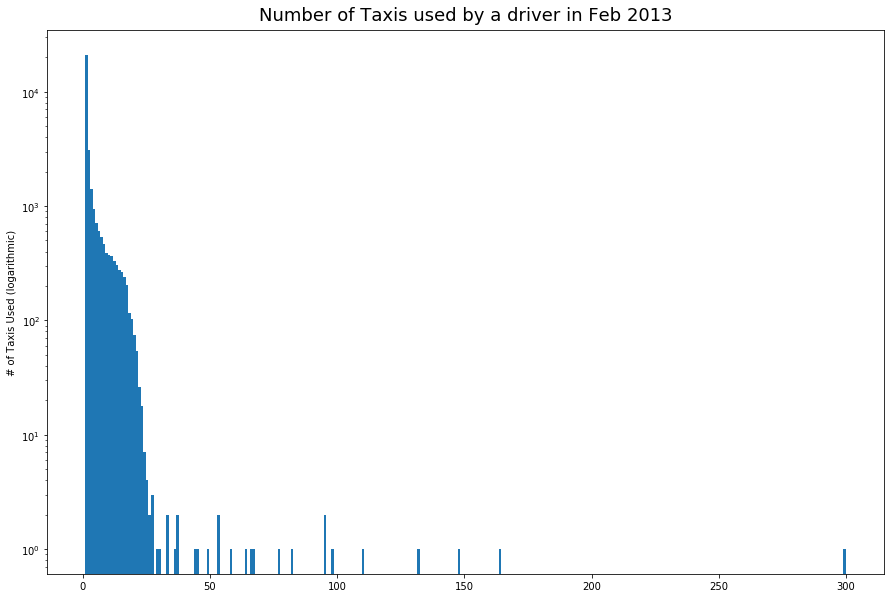

In [116]:
byField = '# of Taxis'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Number of Taxis used by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist',   bins=driverInfo['# of Taxis'].max(), ax=ax)
ax.set_yscale('log')
ax.set_ylabel("# of Taxis Used (logarithmic)")

if dt == "Jan 2013":
    ax.text(250, ax.get_ylim()[0] + ax.get_ylim()[1] /5000, "1 Driver logged 333 different vehicles")
    
plt.show()


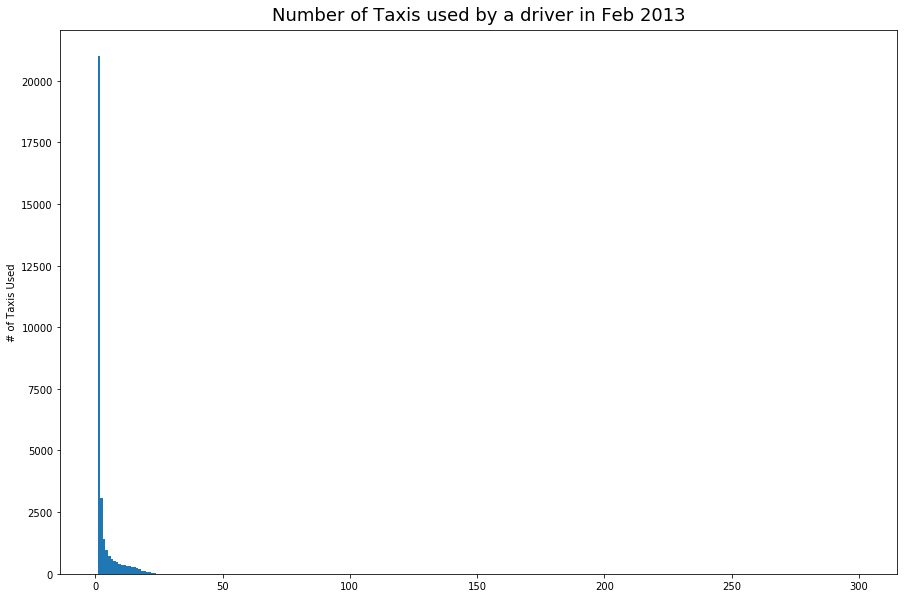

In [117]:
byField = '# of Taxis'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Number of Taxis used by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist',   bins=driverInfo['# of Taxis'].max(), ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel("# of Taxis Used")


plt.show()


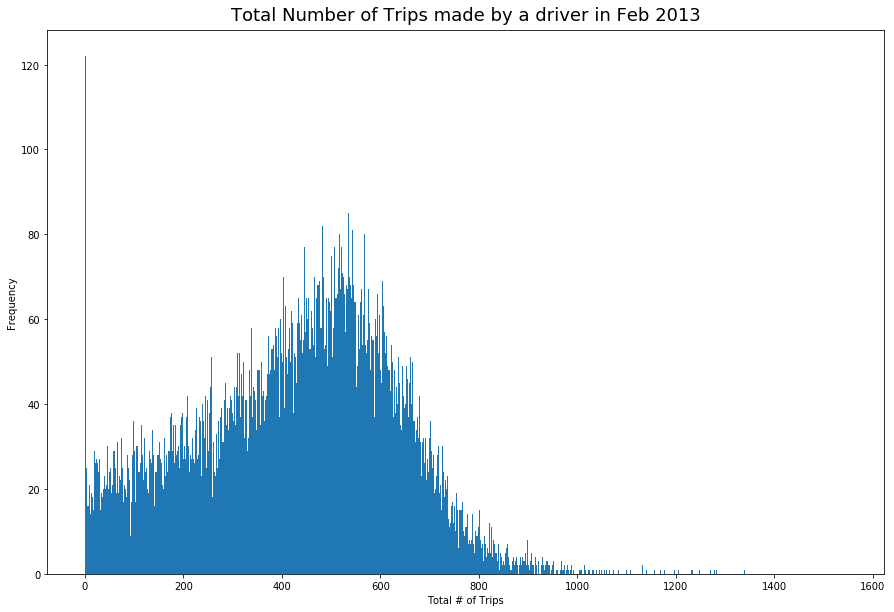

In [118]:
byField = 'Trip Count (sum)'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Total Number of Trips made by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist', bins=driverInfo[byField].max(), ax=ax)
ax.set_xlabel("Total # of Trips")
if dt == "Jan 2013":
    ax.text(3, ax.get_ylim()[0] + ax.get_ylim()[1] /1.2, "%.0f Drivers only made one trip, with an Mean of %.1f mins a trip."  \
    "\n    \
    (Min:%.0f, Max:%.0f, SD: %.1f)" % (driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].count(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mean(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].min(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].max(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].std()))

plt.show()


In [119]:
#Calc for the above chart
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].count())
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mean())
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].min())
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mode())

122
10.798633879781423
0.0
0    0.0
1    1.0
dtype: float64


In [120]:
#Counter(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].astype(int))

In [121]:
print( "%.0f Drivers only made one trip, with an average of %.1f mins a trip."  \
    "(min:%.1f, Max:%.1f, SD: %.1f)" % (driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].count(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mean(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].min(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].max(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].std()))

122 Drivers only made one trip, with an average of 10.8 mins a trip.(min:0.0, Max:53.2, SD: 11.8)


### Trips per taxi

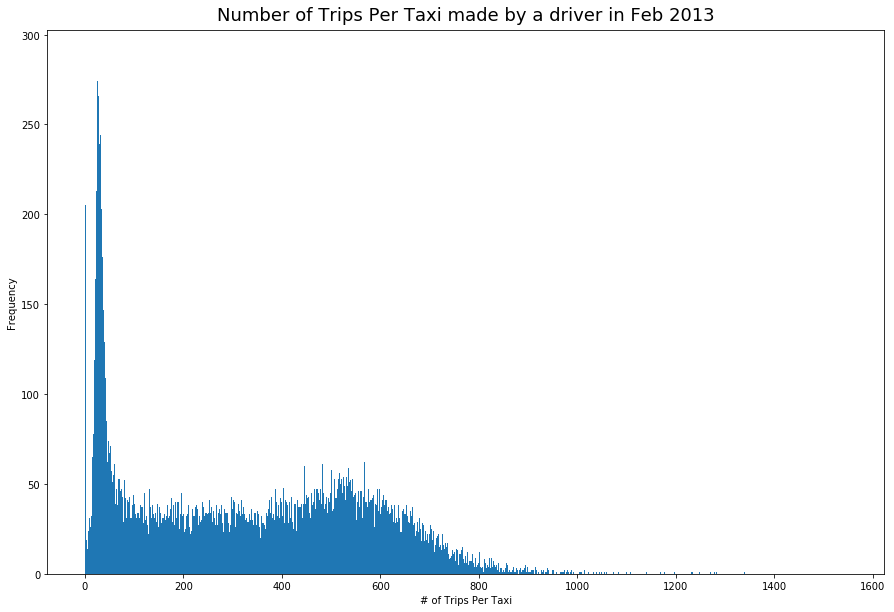

In [122]:
byField = 'Trips Per Taxi'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Number of Trips Per Taxi made by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist', bins=driverInfo[byField].astype(int).max(), ax=ax)
ax.set_xlabel("# of Trips Per Taxi")

plt.show()

In [123]:

driverInfo.head()

Driver  # of Taxis  Fare Amount (sum)  \
0  00B7691D86D96AEBD21DD9E138F90840         300             3356.0   
1  AF21D0C97DB2E27E13572CBF59EB343D         164              748.4   
2  C1059E614E05082428C20540004D03CE         148              755.8   
3  B59C67BF196A4758191E42F76670CEBA         132              701.9   
4  C667D53ACD899A97A85DE0C201BA99BE         110              587.3   

   Fare Amount (mean)  Tip Amount (sum)  Tip Amount (mean)  \
0           11.186667             38.45           0.128167   
1            4.563415             11.30           0.068902   
2            5.106757              0.00           0.000000   
3            5.317424              0.00           0.000000   
4            5.339091              0.00           0.000000   

   Total Amount (sum)  Total Amount (mean)  Trip Time (sec) (sum)  \
0             3858.25            12.860833                 183600   
1              881.95             5.377744                  20854   
2              871.30             5.887162                  28925   
3              861.15             6.523864                  15274   
4              665.80             6.052727                  15352   

   Trip Time (sec) (mean)  Trip Count (sum)  Trip Count (mean)  \
0              612.000000               652           2.173333   
1              127.158537               213           1.298780   
2              195.439189               223           1.506757   
3              115.712121               187           1.416667   
4              139.563636               152           1.381818   

   Trips Per Taxi  Fare Per Trip  Tip Per Trip  Amount Per Trip  \
0        2.173333       5.147239      0.058972         5.917561   
1        1.298780       3.513615      0.053052         4.140610   
2        1.506757       3.389238      0.000000         3.907175   
3        1.416667       3.753476      0.000000         4.605080   
4        1.381818       3.863816      0.000000         4.380263   

   Journey Time (sec) Per Trip  Journey Time (mins) Per Trip  \
0                   281.595092                      4.693252   
1                    97.906103                      1.631768   
2                   129.708520                      2.161809   
3                    81.679144                      1.361319   
4                   101.000000                      1.683333   

   Trip Time (mins) (sum)  Trip Time (hrs) (sum)  Trip Time (mins) (mean)  \
0             3060.000000              51.000000                10.200000   
1              347.566667               5.792778                 2.119309   
2              482.083333               8.034722                 3.257320   
3              254.566667               4.242778                 1.928535   
4              255.866667               4.264444                 2.326061   

  Taxi Use  
0  Extreme  
1  Extreme  
2  Extreme  
3  Extreme  
4  Extreme

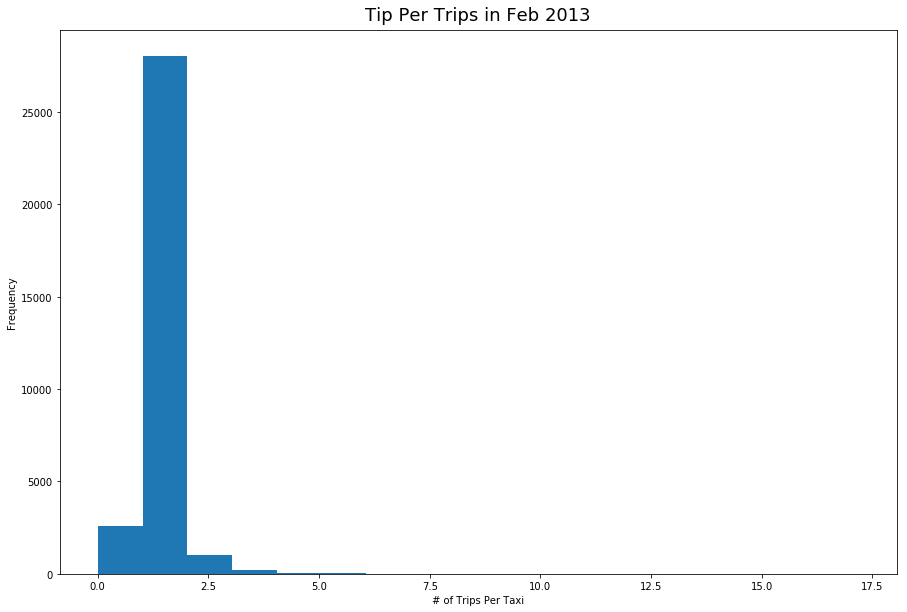

In [124]:
byField = 'Tip Per Trip'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Tip Per Trips in ' + dt, title_font)

driverInfo[byField].plot(kind='hist',   bins=driverInfo[byField].max().astype(int), ax=ax)
ax.set_xlabel("# of Trips Per Taxi")

plt.show()

## Scatter Plots

To Do: Fix Axis so that they are the same

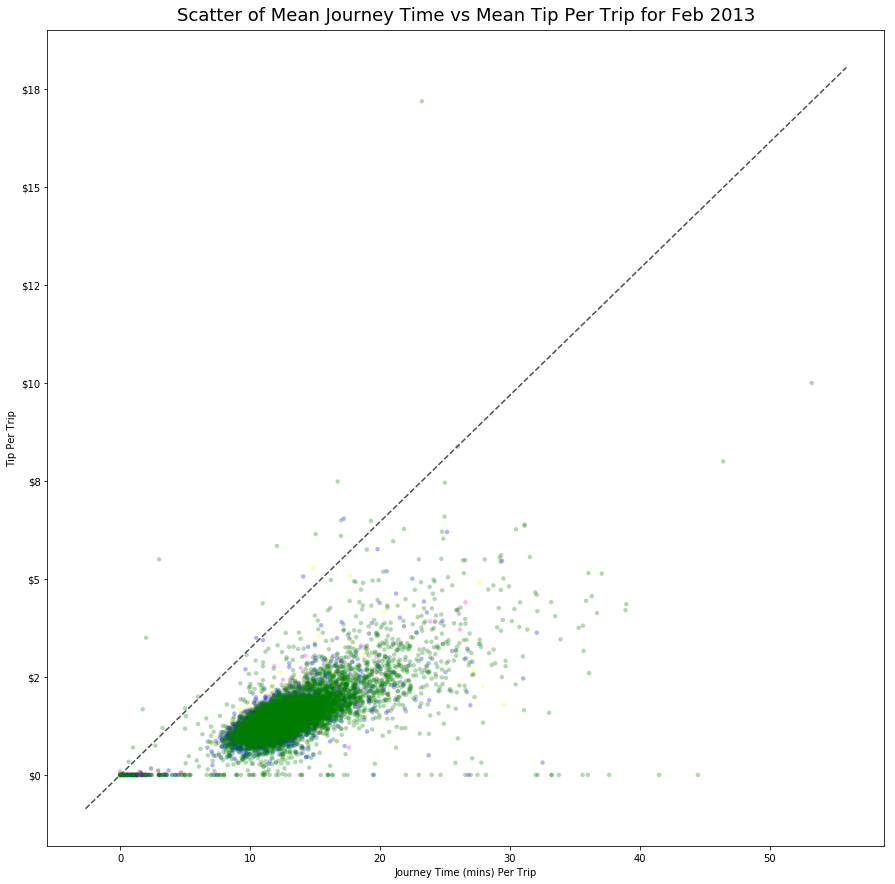

In [125]:
#plot
alpha = 0.3
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Scatter of Mean Journey Time vs Mean Tip Per Trip for ' + dt, title_font)

colors = {"Error":'red', "Single Use":'green', "Low":'blue', "Medium":'yellow', "High":'magenta', "Extreme":'black'}

driverInfo.plot(kind='scatter', y='Tip Per Trip', x='Journey Time (mins) Per Trip',\
                c=driverInfo['Taxi Use'].apply(lambda x: colors[x]), \
                s=20, ax=ax, lw=0, alpha=alpha)


formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

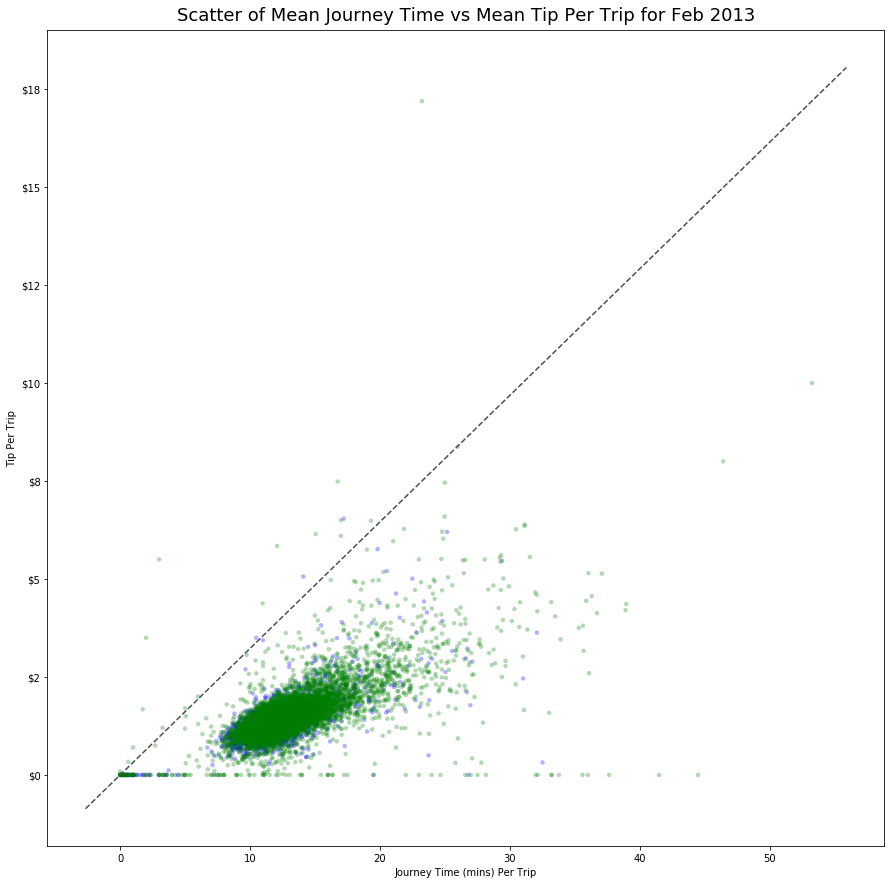

In [126]:
#plot
alpha = 0.3
filter=["Single Use","Low"]

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Scatter of Mean Journey Time vs Mean Tip Per Trip for ' + dt, title_font)

colors = {"Error":'red', "Single Use":'green', "Low":'blue', "Medium":'cyan', "High":'magenta', "Extreme":'black'}

driverInfo[driverInfo['Taxi Use'].isin(filter)].plot(kind='scatter', y='Tip Per Trip', x='Journey Time (mins) Per Trip',\
                c=driverInfo['Taxi Use'][driverInfo['Taxi Use'].isin(filter)].apply(lambda x: colors[x]), \
                s=20, ax=ax, lw=0, alpha=alpha)


formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

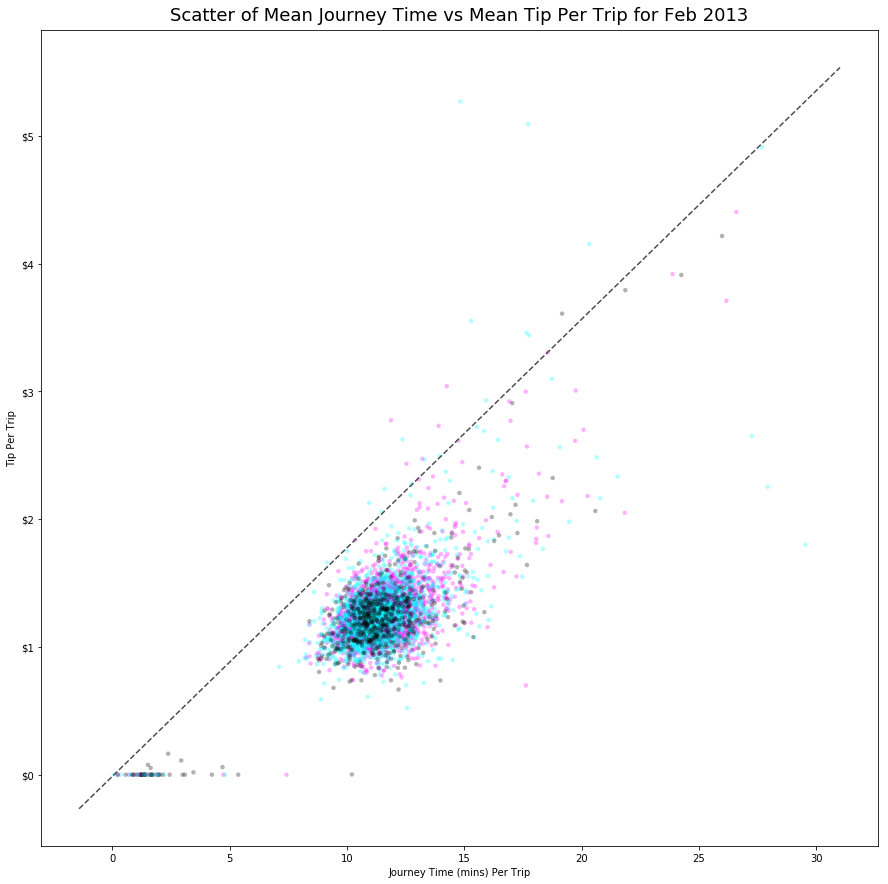

In [127]:
#plot
alpha = 0.3
filter=["Single Use","Low"]

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Scatter of Mean Journey Time vs Mean Tip Per Trip for ' + dt, title_font)

colors = {"Error":'red', "Single Use":'green', "Low":'blue', "Medium":'cyan', "High":'magenta', "Extreme":'black'}

driverInfo[~driverInfo['Taxi Use'].isin(filter)].plot(kind='scatter', y='Tip Per Trip', x='Journey Time (mins) Per Trip',\
                c=driverInfo['Taxi Use'][~driverInfo['Taxi Use'].isin(filter)].apply(lambda x: colors[x]), \
                s=20, ax=ax, lw=0, alpha=alpha)


formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

In [128]:
tripDataFare.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_datetime_dt', 'dropoff_datetime_dt',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'trip_time_in_min', 'pickup_day',
       'pickup_month', 'pickup_year', 'pickup_date', 'pickup_weekday',
       'pickup_isoweekday', 'pickup_hour', 'pickup_minute', 'pickup_time',
       'pickup_dayName', 'pickup_weekdayWeekend', 'pickup_timeOfDay',
       'dropoff_day', 'dropoff_month', 'dropoff_year', 'dropoff_date',
       'dropoff_weekday', 'dropoff_isoweekday', 'dropoff_hour',
       'dropoff_minute', 'dropoff_time', 'dropoff_dayName',
       'dropoff_weekdayWeekend', 'dropoff_timeOfDay', 'tripLength',
       'tripDuration'],
      dtype='ob

In [129]:
tripDataFare = pd.merge(tripDataFare, driverInfo[['Driver', 'Taxi Use']], \
                        how='left', left_on = ['hack_license'], right_on = ['Driver'])
# dont need the extra column as it is the same
tripDataFare.drop('Driver', axis=1)
tripDataFare.head()

medallion                      hack_license  \
0  1B5C0970F2AE8CFFBA8AE4584BEAED29  D961332334524990D1BBD462E2EFB8A4   
1  B42249AE16E2B8E556F1CB1F940D6FB4  D4BB308D1F3FCB3434D9DB282CDC93D7   
2  890699222C47C09FBC898758CEC69762  6318C3AEC02248928C3345B5805EB905   
3  74B7D835C2CD98606D5256DA8A38E045  D5E278C918256D1F97680A1F04D290E0   
4  4003B8478418FEC5D761E2F37602769B  0B766F1054A5C16D86BC023858BD8143   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-02-08 23:35:14   
1       CMT          1                  N  2013-02-07 12:20:16   
2       CMT          1                  N  2013-02-08 08:56:54   
3       CMT          1                  N  2013-02-08 09:37:02   
4       CMT          1                  N  2013-02-08 19:31:25   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-02-08 23:42:58                1                463            0.8   
1  2013-02-07 12:50:27                4               1810            3.1   
2  2013-02-08 08:59:43                1                168            1.0   
3  2013-02-08 09:50:50                1                828            2.1   
4  2013-02-08 19:46:23                1                897            3.3   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.992439        40.724487         -73.984421         40.718903   
1        -73.989494        40.769588         -73.990303         40.737347   
2        -73.963036        40.799141         -73.972168         40.786446   
3        -73.987953        40.728764         -74.007118         40.705399   
4        -73.987282        40.743042         -74.010284         40.703964   

   pickup_datetime_dt dropoff_datetime_dt payment_type  fare_amount  \
0 2013-02-08 23:35:14 2013-02-08 23:42:58          CRD          6.0   
1 2013-02-07 12:20:16 2013-02-07 12:50:27          CRD         20.0   
2 2013-02-08 08:56:54 2013-02-08 08:59:43          CRD          5.0   
3 2013-02-08 09:37:02 2013-02-08 09:50:50          CRD         11.0   
4 2013-02-08 19:31:25 2013-02-08 19:46:23          CRD         13.0   

   surcharge  mta_tax  tip_amount  tolls_amount  total_amount  \
0        0.5      0.5         0.0           0.0           7.0   
1        0.0      0.5         3.0           0.0          23.5   
2        0.0      0.5         1.1           0.0           6.6   
3        0.0      0.5         2.3           0.0          13.8   
4        1.0      0.5         1.5           0.0          16.0   

   trip_time_in_min  pickup_day  pickup_month  pickup_year pickup_date  \
0          7.716667           8             2         2013  2013-02-08   
1         30.166667           7             2         2013  2013-02-07   
2          2.800000           8             2         2013  2013-02-08   
3         13.800000           8             2         2013  2013-02-08   
4         14.950000           8             2         2013  2013-02-08   

   pickup_weekday  pickup_isoweekday  pickup_hour  pickup_minute pickup_time  \
0               4                  5           23             35    23:35:14   
1               3                  4           12             20    12:20:16   
2               4                  5            8             56    08:56:54   
3               4                  5            9             37    09:37:02   
4               4                  5           19             31    19:31:25   

  pickup_dayName pickup_weekdayWeekend   pickup_timeOfDay  dropoff_day  \
0         Friday               Weekday            Evening            8   
1       Thursday               Weekday       Late morning            7   
2         Friday               Weekday  Morning Rush Hour            8   
3         Friday               Weekday  Morning Rush Hour            8   
4         Friday               Weekday  Evening Rush Hour            8   

   dropoff_month  dropoff_year dropoff_date  dropoff_weekday  \
0          

In [130]:
del driverInfo, driverTaxiJourneys, driverVehicle
gc.collect()

111366

In [131]:
del visDataFareRevenue, visDataPassenger,  visDataRevenue, visDataTrips, visDataTripsPassengers, \
visDataTripsPassengersRevenue, visDataTripsPassengersRevenueFareRevenue

gc.collect()

266

## Boxplots


In [132]:
def comparisonBoxplots(xaxis, yaxis, palette, title="No Title Supplied", showmeans=True, showfliers=True):
    fig = plt.figure(1, figsize=(10,5))
    ax = sns.boxplot(x=xaxis, y=yaxis, palette=palette, showmeans=showmeans, showfliers=showfliers)
    # set the title of the chart
    plt.title(title)
    # set the labels - x  is blank because we don't need it to say "Summary"
    ax.set(xlabel='', ylabel='')
    # set the labels on the individual x-axis columns
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=25)
    plt.show()
    print('-' * 100)
    return



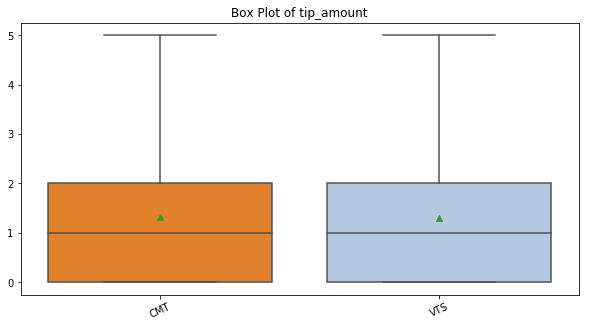

----------------------------------------------------------------------------------------------------


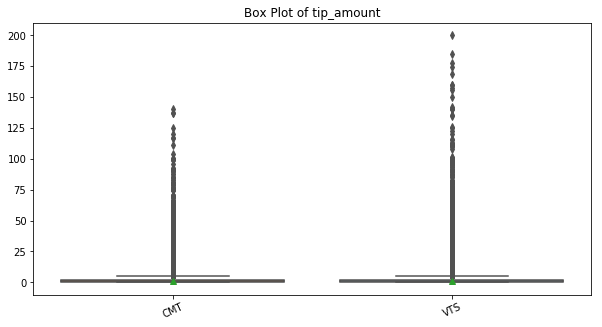

----------------------------------------------------------------------------------------------------


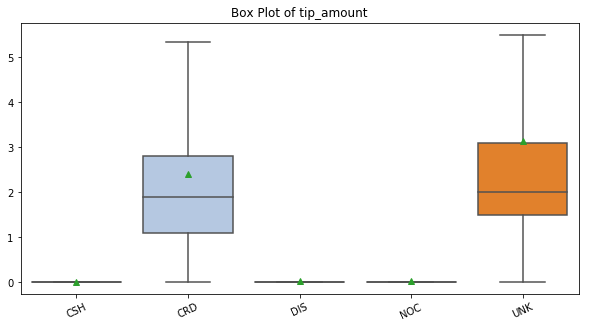

----------------------------------------------------------------------------------------------------


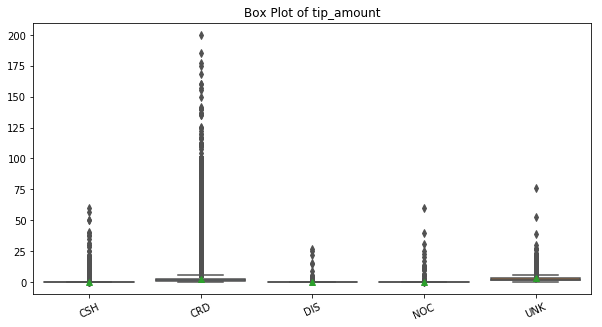

----------------------------------------------------------------------------------------------------


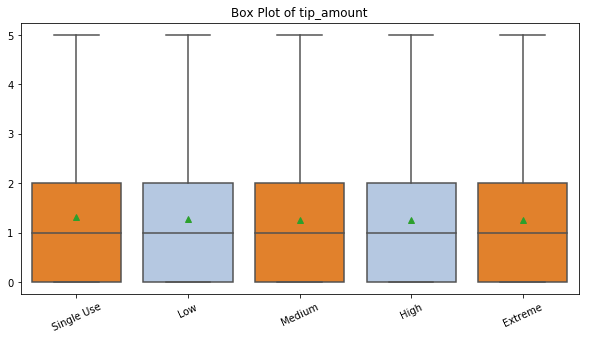

----------------------------------------------------------------------------------------------------


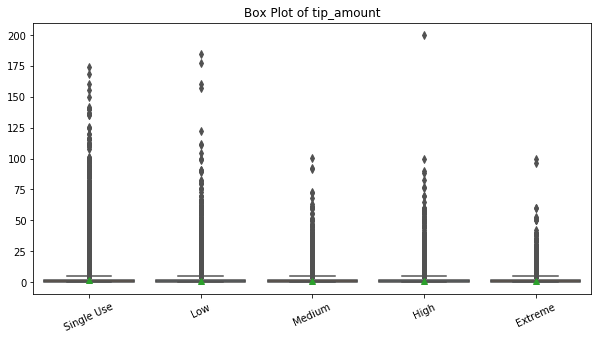

----------------------------------------------------------------------------------------------------


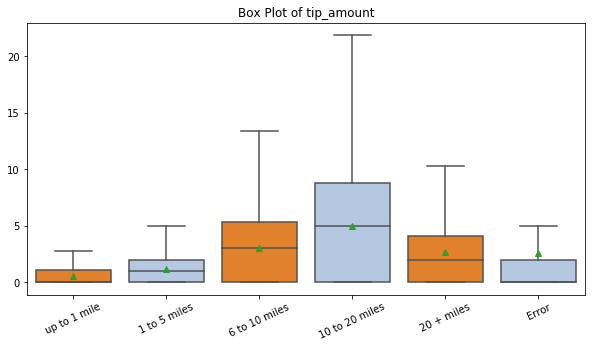

----------------------------------------------------------------------------------------------------


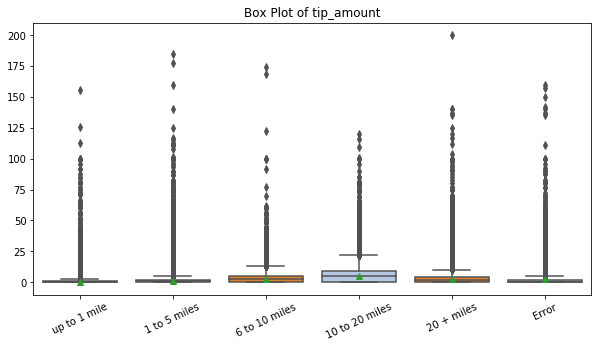

----------------------------------------------------------------------------------------------------


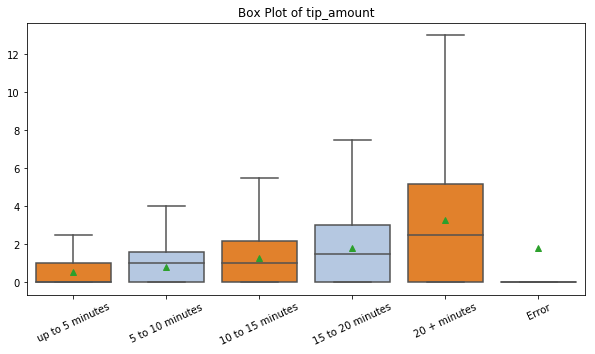

----------------------------------------------------------------------------------------------------


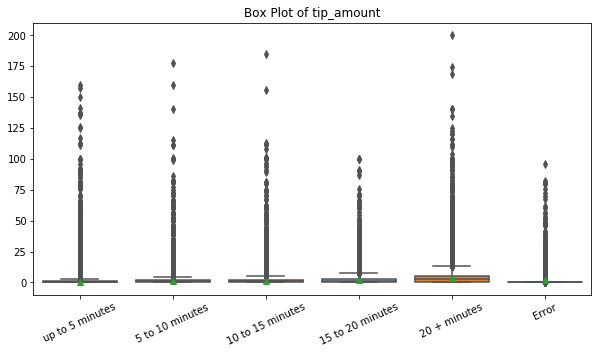

----------------------------------------------------------------------------------------------------


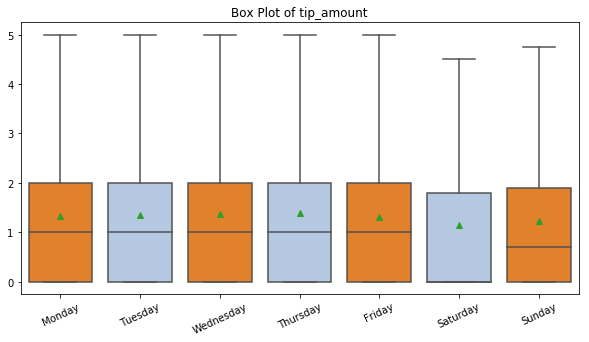

----------------------------------------------------------------------------------------------------


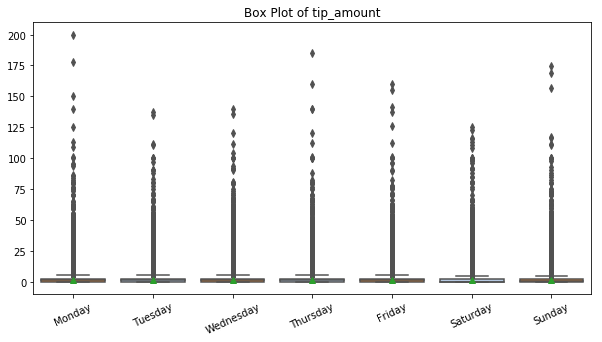

----------------------------------------------------------------------------------------------------


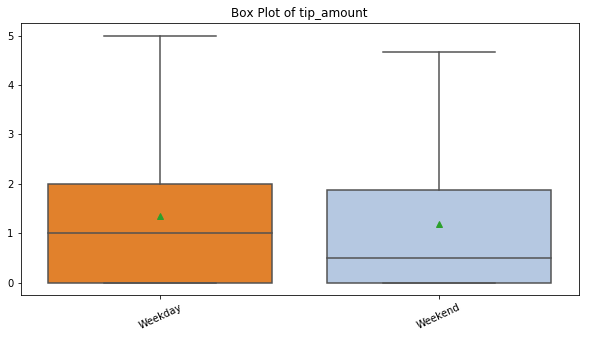

----------------------------------------------------------------------------------------------------


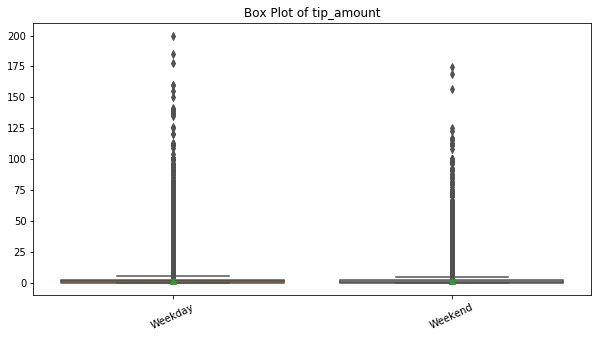

----------------------------------------------------------------------------------------------------


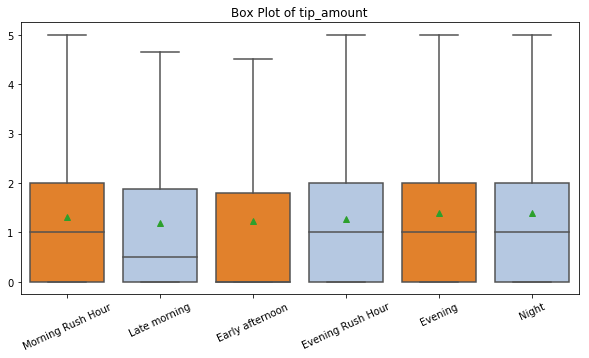

----------------------------------------------------------------------------------------------------


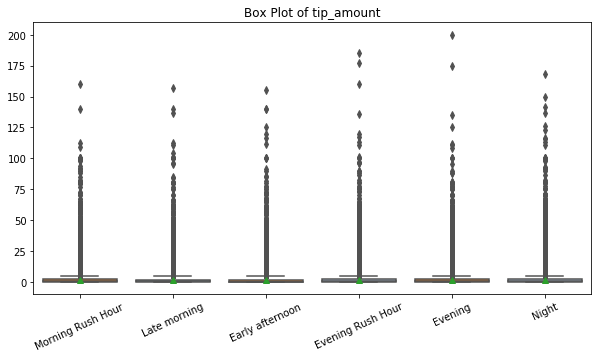

----------------------------------------------------------------------------------------------------


In [133]:
plotValue = ['tip_amount']
byValue = ['vendor_id', 'payment_type', 'Taxi Use', 'tripLength', 'tripDuration',  'pickup_dayName', \
           'pickup_weekdayWeekend', 'pickup_timeOfDay']

for pv in plotValue:
    for bv in byValue:
        #reorder the df to print nicely
        key = tripDataFare[bv].map(retOrderMapping(bv))
        tripDataFare = tripDataFare.iloc[key.argsort()]
        #print the first chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=False)
        # print the second chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=True)

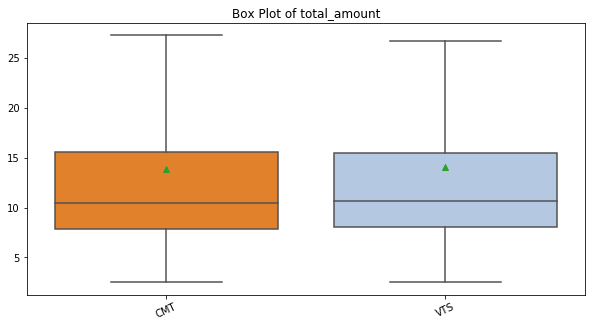

----------------------------------------------------------------------------------------------------


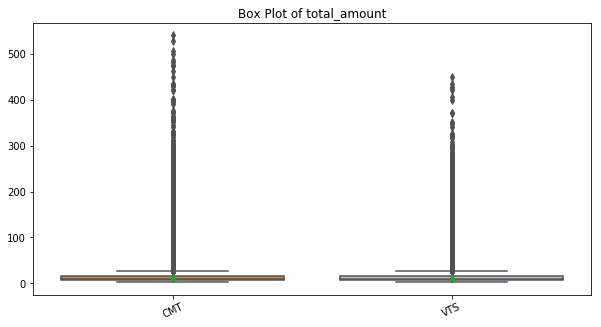

----------------------------------------------------------------------------------------------------


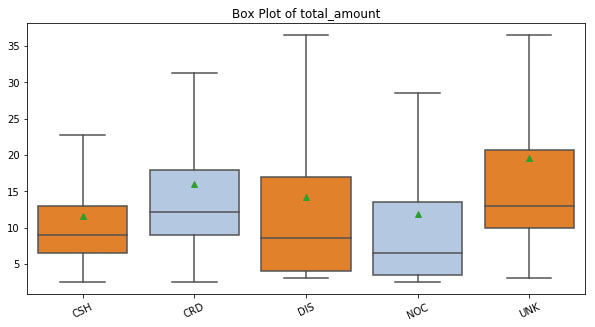

----------------------------------------------------------------------------------------------------


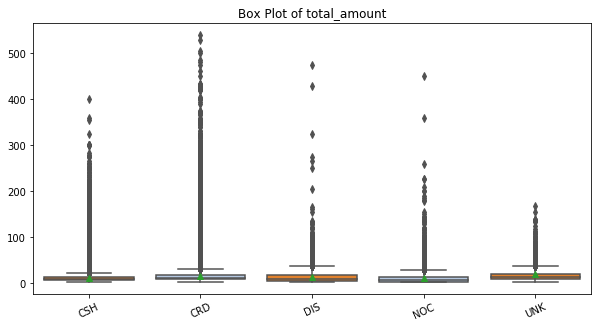

----------------------------------------------------------------------------------------------------


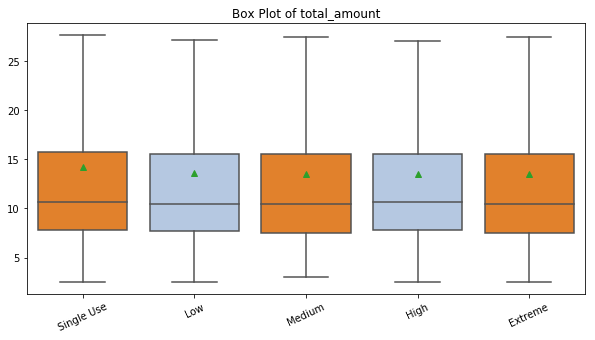

----------------------------------------------------------------------------------------------------


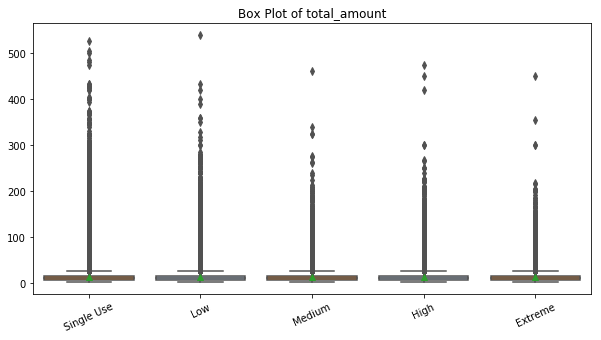

----------------------------------------------------------------------------------------------------


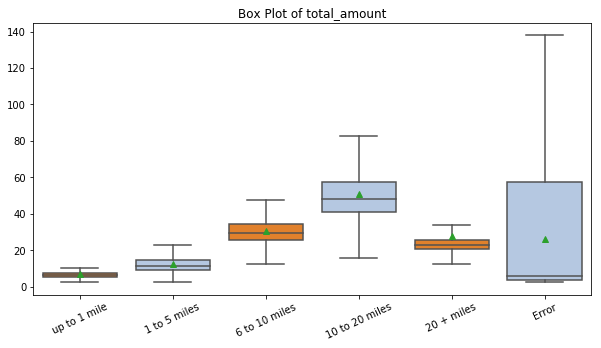

----------------------------------------------------------------------------------------------------


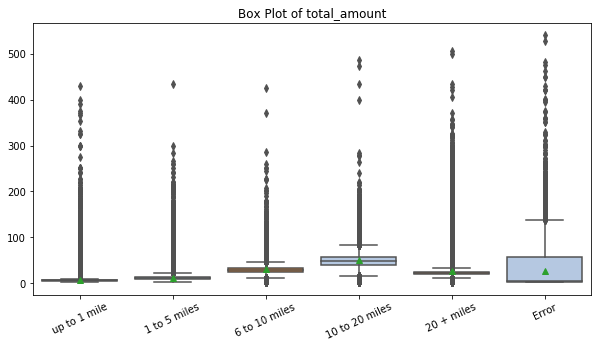

----------------------------------------------------------------------------------------------------


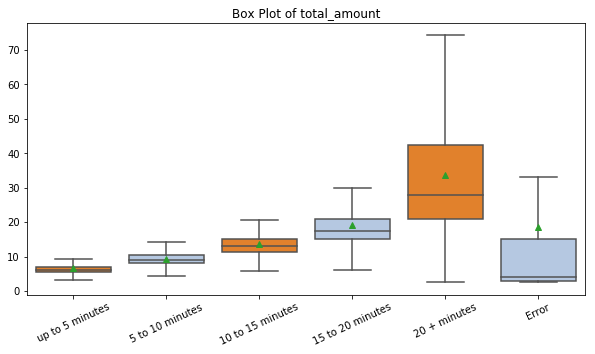

----------------------------------------------------------------------------------------------------


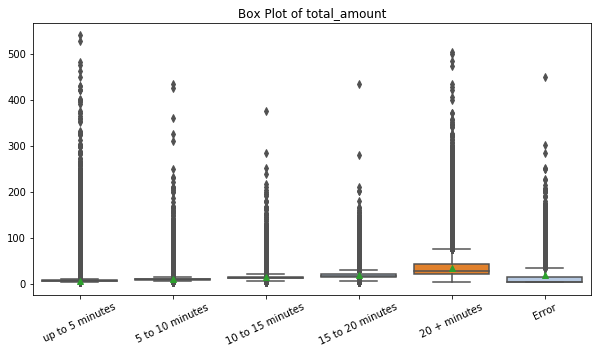

----------------------------------------------------------------------------------------------------


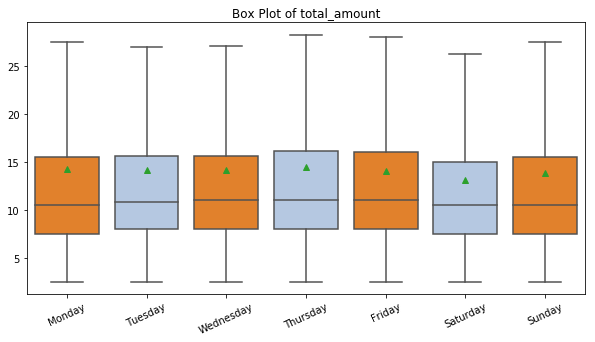

----------------------------------------------------------------------------------------------------


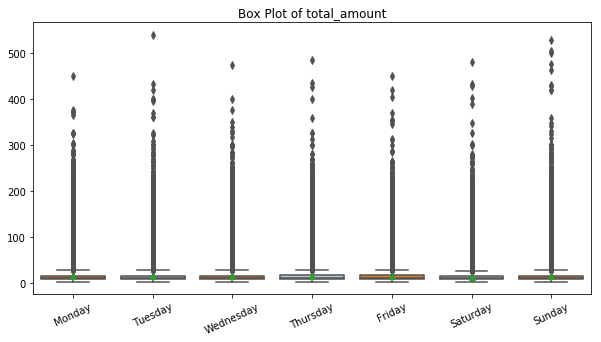

----------------------------------------------------------------------------------------------------


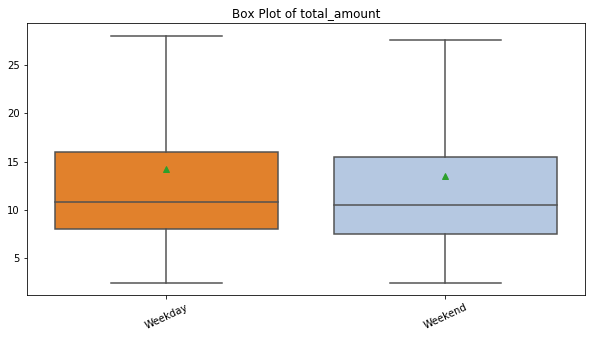

----------------------------------------------------------------------------------------------------


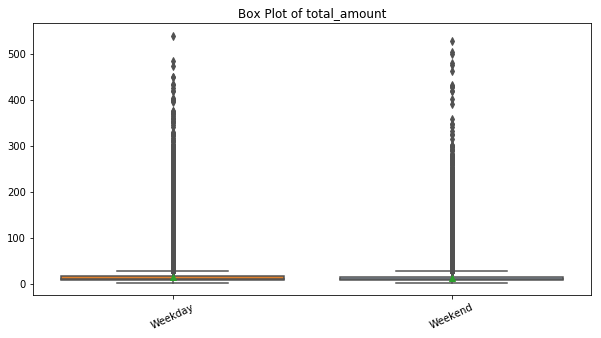

----------------------------------------------------------------------------------------------------


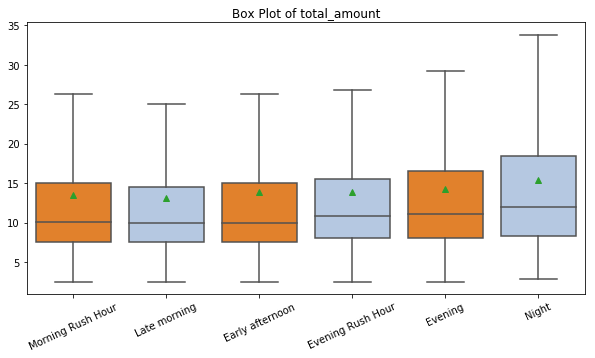

----------------------------------------------------------------------------------------------------


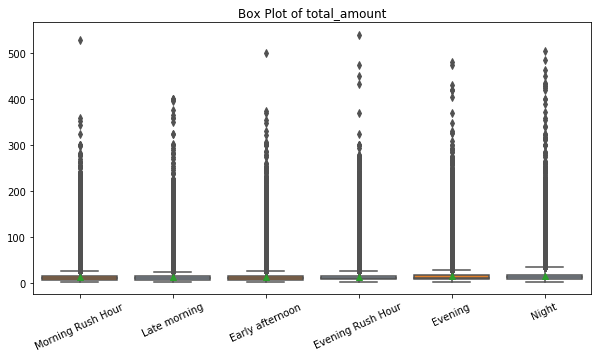

----------------------------------------------------------------------------------------------------


In [134]:
plotValue = ['total_amount']
byValue = ['vendor_id', 'payment_type', 'Taxi Use', 'tripLength', 'tripDuration',  'pickup_dayName', \
           'pickup_weekdayWeekend', 'pickup_timeOfDay']

for pv in plotValue:
    for bv in byValue:
        #reorder the df to print nicely
        key = tripDataFare[bv].map(retOrderMapping(bv))
        tripDataFare = tripDataFare.iloc[key.argsort()]
        #print the first chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=False)
        # print the second chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=True)

In [135]:

#tripDataFare.to_pickle('tripDataFare_Jan_Final.pkl')

In [136]:
dir()

['FuncFormatter',
 'Geocoder',
 'In',
 'Out',
 '_',
 '_100',
 '_102',
 '_109',
 '_111',
 '_112',
 '_114',
 '_12',
 '_123',
 '_128',
 '_129',
 '_130',
 '_131',
 '_15',
 '_16',
 '_17',
 '_21',
 '_39',
 '_41',
 '_44',
 '_46',
 '_47',
 '_49',
 '_51',
 '_55',
 '_57',
 '_59',
 '_69',
 '_79',
 '_8',
 '_80',
 '_82',
 '_83',
 '_86',
 '_87',
 '_90',
 '_91',
 '_92',
 '_95',
 '_96',
 '_99',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i100',
 '_i101',
 '_i102',
 '_i103',
 '_i104',
 '_i105',
 '_i106',
 '_i107',
 '_i108',
 '_i109',
 '_i11',
 '_i110',
 '_i111',
 '_i112',
 '_i113',
 '_i114',
 '_i115',
 '_i116',
 '_i117',
 '_i118',
 '_i119',
 '_i12',
 '_i120',
 '_i121',
 '_i122',
 '_i123',
 '_i124',
 '_i125',
 '_i126',
 '_i127',
 '_i128',
 '_i129',
 '_i13',
 '_i130',
 '_i131',
 '_i132',
 '_i133',
 '_i134',
 '_i135',
 '_i136',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 